Please upload your CSV (first column = time).


Saving equipment_degradation_timeseries_forecasting_dataset.csv to equipment_degradation_timeseries_forecasting_dataset (14).csv
Loaded: equipment_degradation_timeseries_forecasting_dataset (14).csv
Detected time column: t
Numeric target columns: ['ds1_observed', 'ds2_observed', 'ds3_observed']

Target series: ds1_observed
Inferred frequency: <Nano>
Seasonal candidates: None
Train size: 4000, Test size: 1000
TBATS not available (install error).

Performance (lower is better):
Theta          | sMAPE=22.45%  MAPE=22.52%  RMSE=0.1543
ETS            | sMAPE=37.39%  MAPE=31.94%  RMSE=0.2379
Naive          | sMAPE=39.29%  MAPE=33.02%  RMSE=0.2462
SARIMAX        | sMAPE=49.01%  MAPE=38.66%  RMSE=0.284


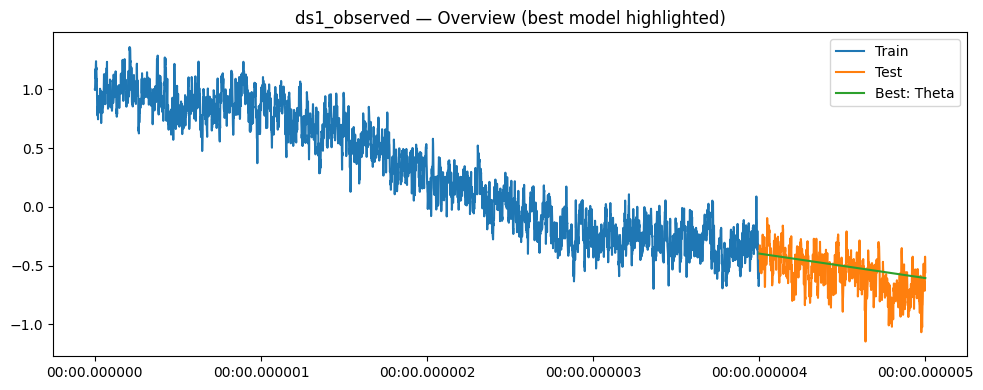

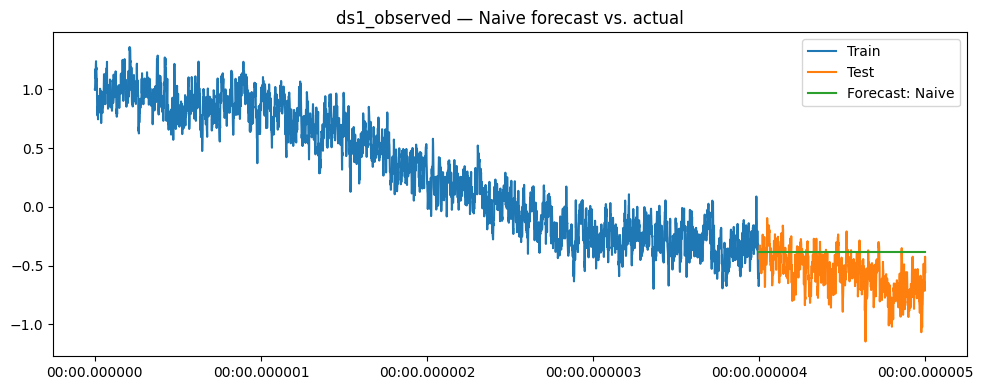

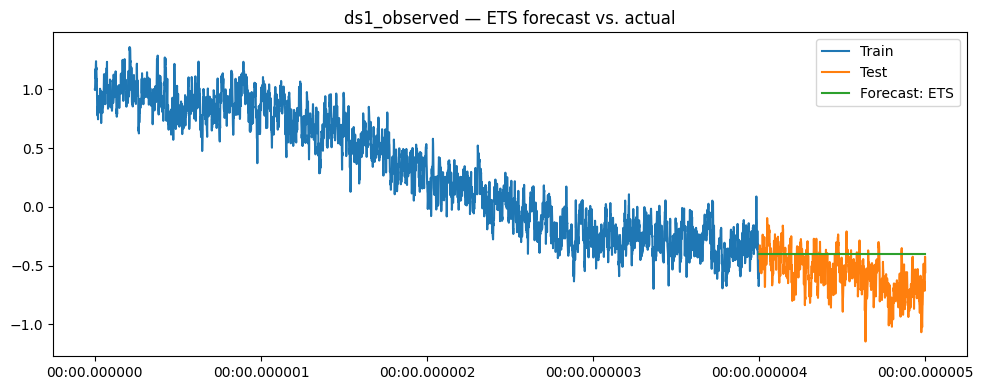

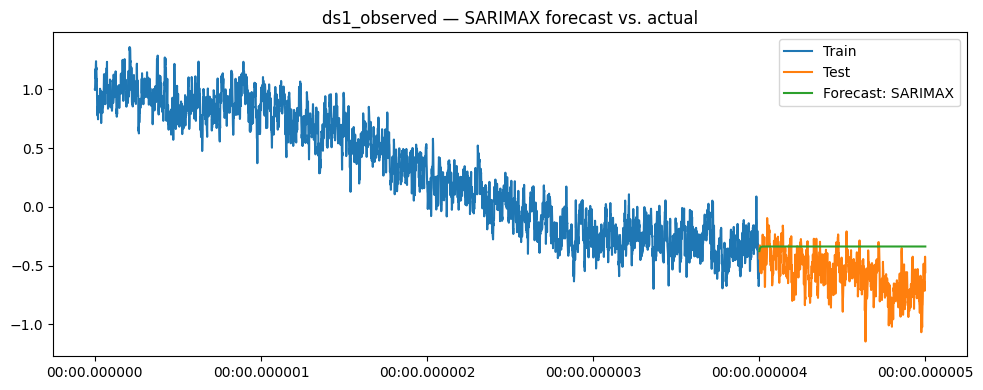

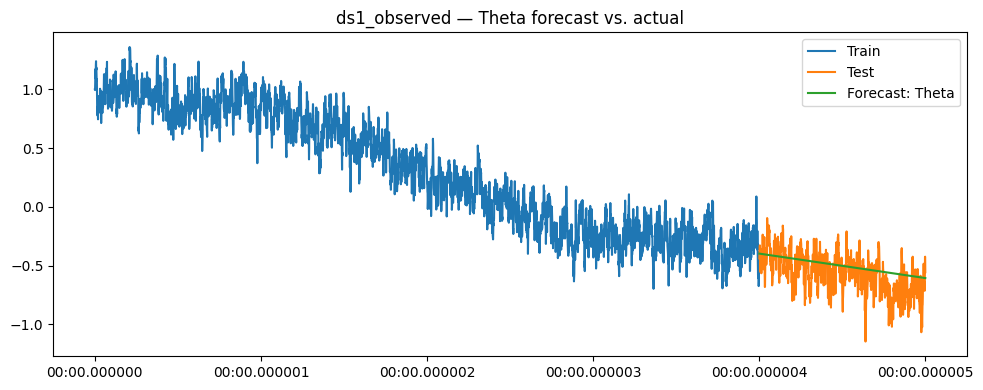


Target series: ds2_observed
Inferred frequency: <Nano>
Seasonal candidates: None
Train size: 4000, Test size: 1000
TBATS not available (install error).

Performance (lower is better):
Naive          | sMAPE=13.74%  MAPE=14.44%  RMSE=0.1458
Theta          | sMAPE=13.76%  MAPE=14.18%  RMSE=0.1467
ETS            | sMAPE=14.07%  MAPE=14.09%  RMSE=0.15
SARIMAX        | sMAPE=14.13%  MAPE=14.10%  RMSE=0.1507


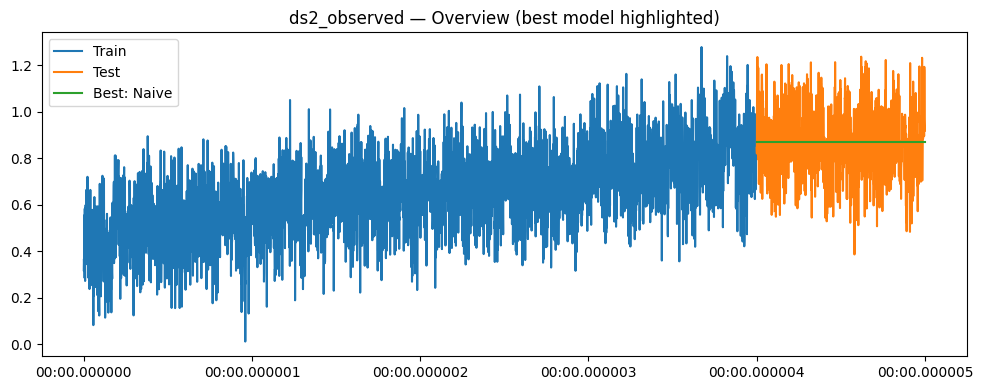

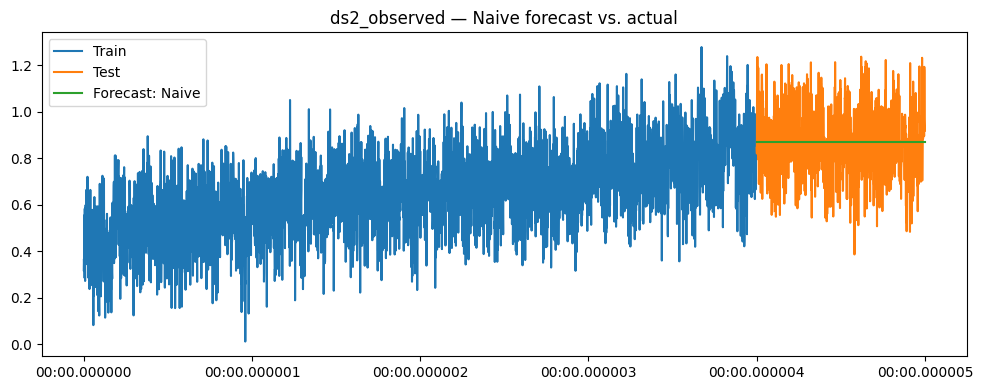

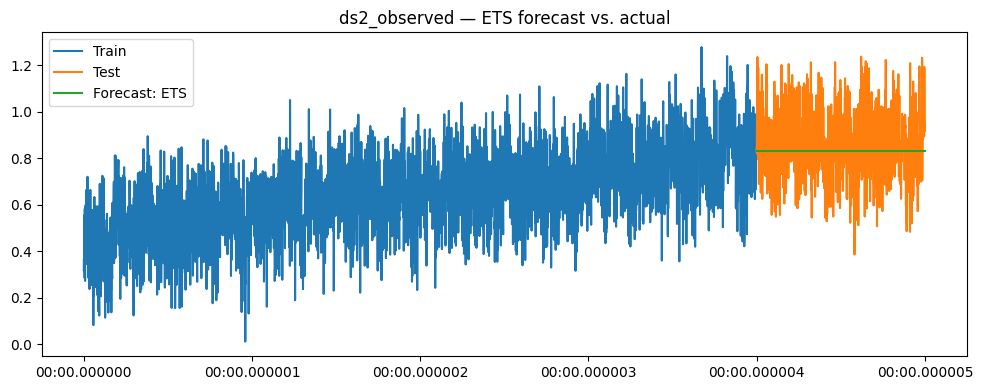

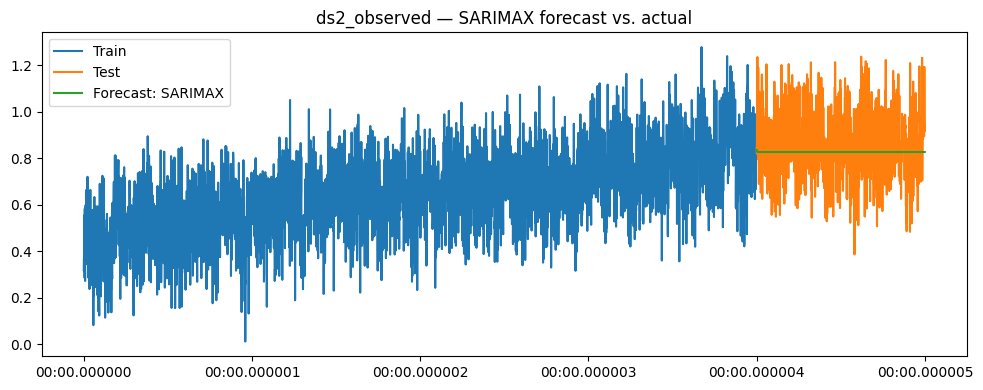

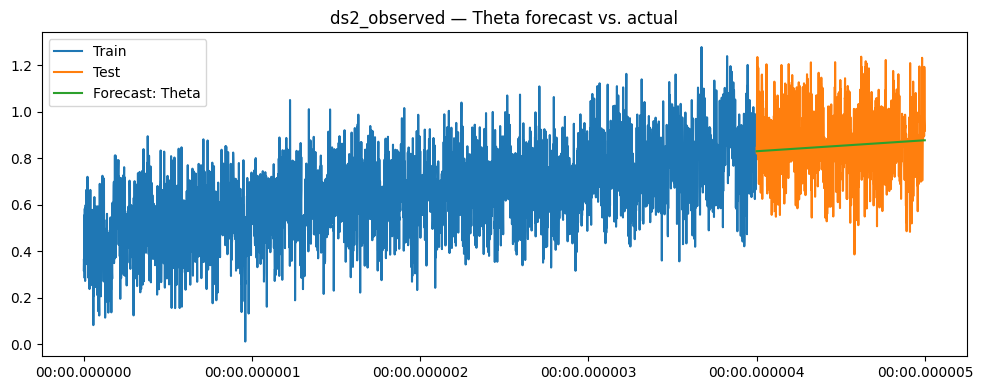


Target series: ds3_observed
Inferred frequency: <Nano>
Seasonal candidates: None
Train size: 4000, Test size: 1000
TBATS not available (install error).

Performance (lower is better):
Theta          | sMAPE=72.49%  MAPE=493.46%  RMSE=0.2138
SARIMAX        | sMAPE=78.10%  MAPE=583.38%  RMSE=0.249
Naive          | sMAPE=79.65%  MAPE=599.16%  RMSE=0.2573
ETS            | sMAPE=82.83%  MAPE=632.17%  RMSE=0.2751


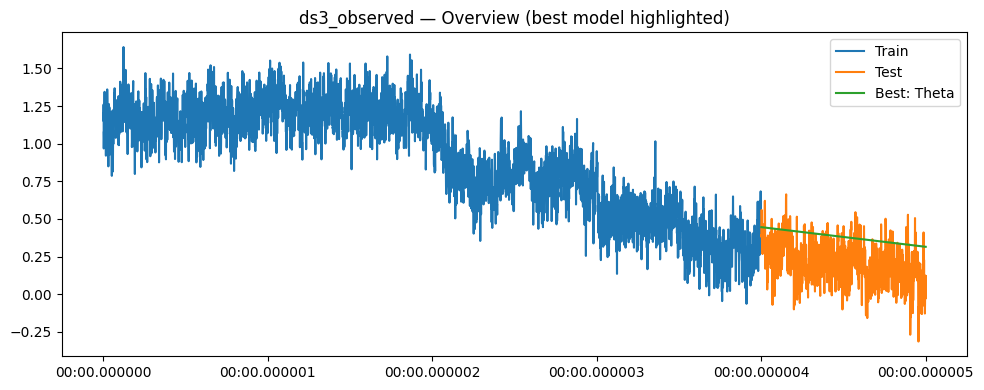

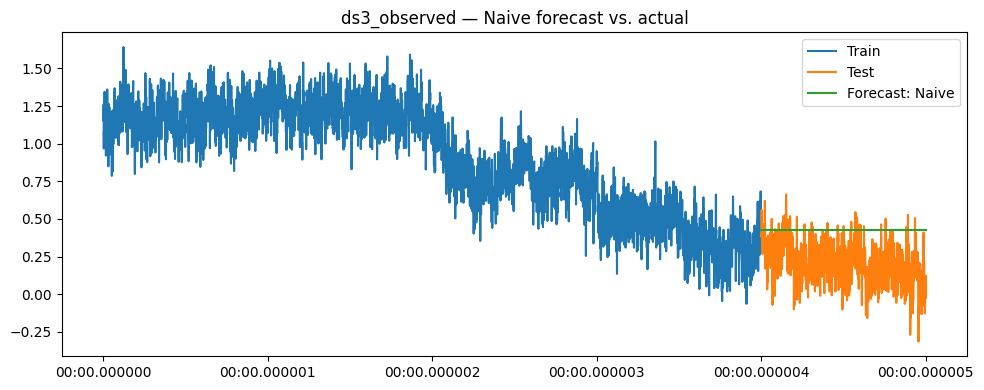

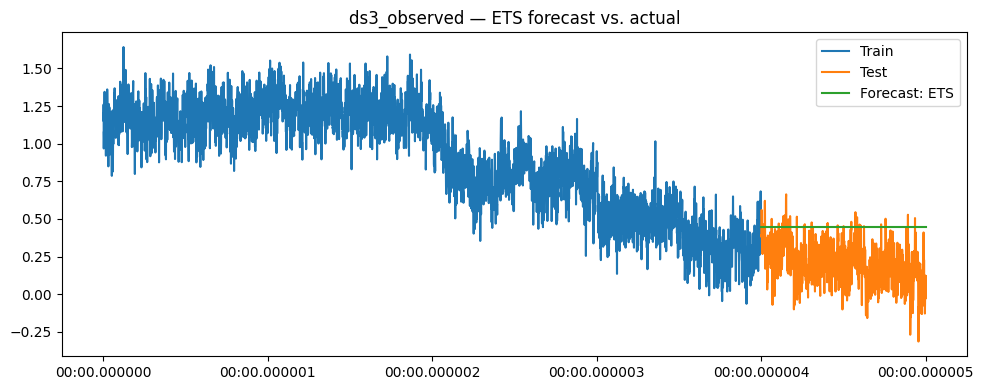

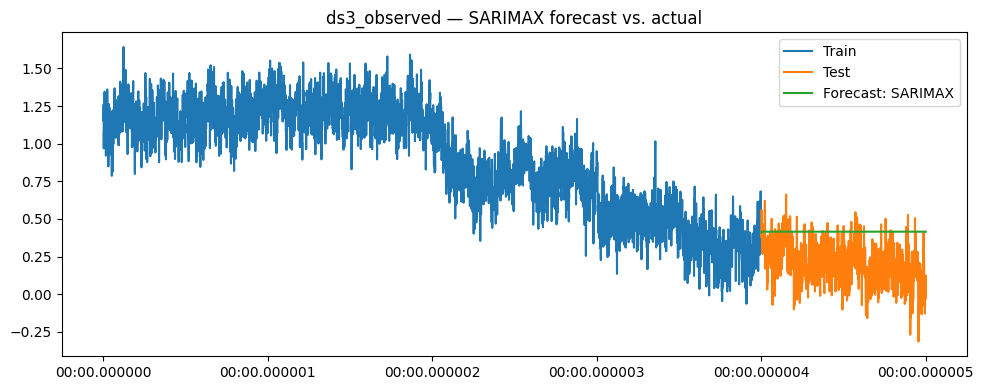

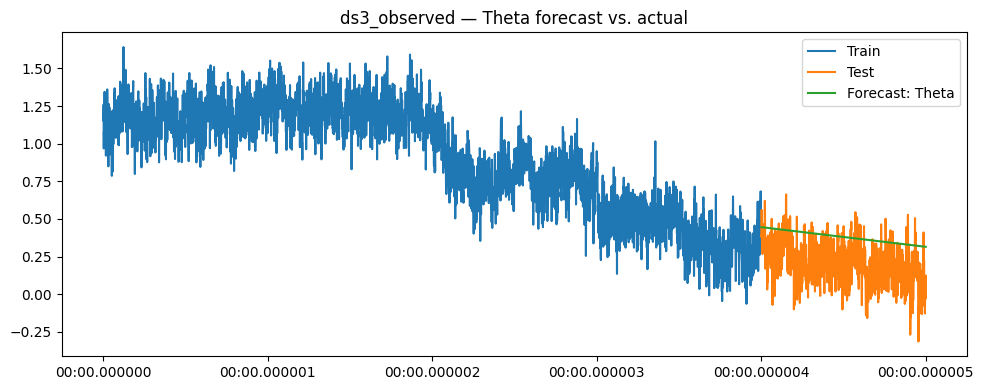


Done. If seasonality looks off, set MANUAL_SEASONAL_PERIODS (e.g., [24, 24*7] or [7, 30] or [12]) and re-run.


In [ ]:
# %% [colab] --- Setup: installs (safe to re-run) ---
!pip -q install tbats --progress-bar off

# %% [colab] --- Imports ---
import warnings, math, sys, itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from google.colab import files

# Statsmodels
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Optional multi-seasonal model
try:
    from tbats import TBATS
    _TBATS_AVAILABLE = True
except Exception:
    _TBATS_AVAILABLE = False

# %% [colab] --- User-adjustable switches ---
MANUAL_SEASONAL_PERIODS = None  # e.g., [24, 24*7] or [7, 30] or [12]
ENABLE_TBATS = True
TEST_SIZE_RATIO = 0.2
MAX_ETS_SECONDS = 30
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)

# %% [colab] --- Upload CSV ---
print("Please upload your CSV (first column = time).")
uploaded = files.upload()
assert uploaded, "No file uploaded."
csv_path = list(uploaded.keys())[0]
print(f"Loaded: {csv_path}")

# %% [colab] --- Read CSV robustly ---
def read_csv_flex(path):
    for sep in [",",";","\t","|"]:
        try:
            df = pd.read_csv(path, sep=sep, engine="python")
            if df.shape[1] >= 2:
                return df
        except: pass
    return pd.read_csv(path)

raw = read_csv_flex(csv_path)
time_col = raw.columns[0]
df = raw.copy()
df[time_col] = pd.to_datetime(df[time_col], errors="coerce", infer_datetime_format=True)
if df[time_col].isna().all():
    raise ValueError("First column couldn't be parsed as datetime.")
df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)
num_cols = [c for c in df.columns if c != time_col and pd.api.types.is_numeric_dtype(df[c])]
if not num_cols:
    raise ValueError("No numeric columns found apart from the first time column.")
print(f"Detected time column: {time_col}")
print(f"Numeric target columns: {num_cols}")
df = df.set_index(time_col)

# %% [colab] --- Frequency inference & regularization ---
def infer_uniform_freq(idx):
    f = pd.infer_freq(idx)
    if f: return f
    if len(idx) < 3: return None
    diffs = (idx[1:] - idx[:-1]).value_counts()
    if len(diffs)==0: return None
    mode_delta = diffs.index[0]
    secs = int(mode_delta / np.timedelta64(1, 's'))
    if secs <= 0: return None
    if secs % (24*3600) == 0:
        d = secs // (24*3600); return f"{d}D" if d!=1 else "D"
    if secs % 3600 == 0:
        h = secs // 3600; return f"{h}H" if h!=1 else "H"
    if secs % 60 == 0:
        m = secs // 60; return f"{m}T" if m!=1 else "T"
    return f"{secs}S" if secs!=1 else "S"

def as_uniform_series(s: pd.Series):
    s = s.dropna()
    s = s[~s.index.duplicated(keep="first")]
    freq = infer_uniform_freq(s.index)
    if freq is None:
        if len(s.index) < 3: return s, None
        diffs = np.diff(s.index.view(np.int64))
        step = int(np.median(diffs))
        new_index = pd.date_range(s.index.min(), s.index.max(), freq=pd.to_timedelta(step, unit="ns"))
        s = s.reindex(new_index).interpolate(limit_direction="both")
        return s.asfreq(s.index.freq), s.index.freq
    else:
        s = s.asfreq(freq)
        if s.isna().any():
            s = s.interpolate(limit_direction="both")
        return s, s.index.freq

def default_seasonal_candidates(freq_str):
    if freq_str is None: return []
    f = str(freq_str).upper()
    if f.endswith('H') or f=='H': return [24, 24*7]          # hourly: daily + weekly
    if f.endswith('T') or 'MIN' in f: return [60, 60*24, 60*24*7]
    if f.endswith('S') or f=='S': return [60, 3600, 86400]
    if 'D' in f: return [7, 30]
    if 'W' in f: return [52]
    if f.startswith('M'): return [12]
    if f.startswith('Q'): return [4]
    return []

def strictly_positive(x): return np.all(np.asarray(x) > 0)

# %% [colab] --- Metrics ---
def smape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    denom = (np.abs(y) + np.abs(yhat)); denom[denom==0]=1e-9
    return 100*np.mean(2*np.abs(yhat-y)/denom)
def mape(y, yhat):
    y = np.asarray(y); y = np.where(y==0, 1e-9, y)
    return 100*np.mean(np.abs((y - np.asarray(yhat))/y))
def rmse(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    return np.sqrt(np.mean((yhat-y)**2))

# %% [colab] --- ETS / SARIMAX / Theta / TBATS helpers ---
from time import time

def fit_ets(y_train, seasonal_period):
    trend_opts = [None, 'add', 'mul']
    seasonal_opts = [None] if not seasonal_period or seasonal_period<2 else ['add','mul']
    best_aic, best_model = np.inf, None
    t0 = time()
    for tr in trend_opts:
        for se in seasonal_opts:
            if time()-t0 > MAX_ETS_SECONDS: break
            if (tr=='mul' or se=='mul') and not strictly_positive(y_train):
                continue
            try:
                m = ExponentialSmoothing(
                    y_train, trend=tr, seasonal=se,
                    seasonal_periods=(seasonal_period if se else None),
                    initialization_method="estimated"
                ).fit(optimized=True, use_brute=False)
                aic = getattr(m, "aic", np.inf)
                if aic < best_aic: best_aic, best_model = aic, m
            except: pass
    return best_model

def _candidate_sarimax_orders(s_period):
    """Small, fast grid."""
    orders = [(0,0,0),(1,0,0),(0,1,1),(1,1,1),(2,1,1)]
    seas_orders = [(0,0,0,0)]
    if s_period and s_period>=2:
        seas_orders = [(0,0,0,s_period),(1,0,0,s_period),(0,1,1,s_period),(1,1,1,s_period)]
    return orders, seas_orders

def fit_sarimax_best(y_train, s_period):
    best_aic, best_model = np.inf, None
    orders, seas = _candidate_sarimax_orders(s_period)
    for (p,d,q) in orders:
        for (P,D,Q,m) in seas:
            try:
                model = SARIMAX(
                    y_train, order=(p,d,q),
                    seasonal_order=(P,D,Q,m),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)
                aic = model.aic
                if aic < best_aic:
                    best_aic, best_model = aic, model
            except:
                continue
    return best_model

def fit_theta(y_train):
    try: return ThetaModel(y_train, deseasonalize=False).fit()
    except: return None

def fit_tbats(y_train, seasonal_periods_list):
    if not (_TBATS_AVAILABLE and ENABLE_TBATS): return None
    if not seasonal_periods_list or len(seasonal_periods_list)<2: return None
    try:
        est = TBATS(
            seasonal_periods=seasonal_periods_list,
            use_box_cox=False, use_trend=True, use_damped_trend=True,
            use_arma_errors=False, n_jobs=1
        )
        return est.fit(y_train)
    except: return None

# %% [colab] --- Main loop over each numeric series ---
all_results = []

for col in num_cols:
    print("\n" + "="*90)
    print(f"Target series: {col}")
    y_raw = df[col].astype(float).copy()
    y, freq = as_uniform_series(y_raw)
    print(f"Inferred frequency: {freq}")

    # Seasonality candidates
    candidates = MANUAL_SEASONAL_PERIODS if MANUAL_SEASONAL_PERIODS else default_seasonal_candidates(freq)
    print("Seasonal candidates:", candidates if candidates else "None")
    s_period = int(candidates[0]) if candidates else None

    # Split
    n = len(y); h = max(1, int(round(TEST_SIZE_RATIO*n)))
    y_train, y_test = y.iloc[:-h], y.iloc[-h:]
    print(f"Train size: {len(y_train)}, Test size: {h}")

    forecasts, metrics = {}, {}

    # Baselines
    forecasts["Naive"] = pd.Series(np.full(h, y_train.iloc[-1]), index=y_test.index)
    if s_period and len(y_train)>s_period:
        base = y_train.iloc[-s_period:].values
        forecasts["SeasonalNaive"] = pd.Series(np.resize(base, h), index=y_test.index)

    # ETS
    ets_model = fit_ets(y_train, s_period)
    if ets_model is not None:
        try:
            forecasts["ETS"] = pd.Series(ets_model.forecast(h), index=y_test.index)
        except: pass
    else:
        print("ETS skipped.")

    # SARIMAX (replacement for pmdarima)
    sarimax_model = fit_sarimax_best(y_train, s_period)
    if sarimax_model is not None:
        try:
            forecasts["SARIMAX"] = pd.Series(sarimax_model.forecast(steps=h), index=y_test.index)
        except: pass
    else:
        print("SARIMAX skipped (no viable order found).")

    # Theta
    theta_model = fit_theta(y_train)
    if theta_model is not None:
        try:
            forecasts["Theta"] = pd.Series(theta_model.forecast(h), index=y_test.index)
        except: pass

    # TBATS (multi-seasonal)
    tbats_model = fit_tbats(y_train, candidates if candidates else [])
    if tbats_model is not None:
        try:
            forecasts["TBATS"] = pd.Series(tbats_model.forecast(steps=h), index=y_test.index)
        except: pass
    elif ENABLE_TBATS and not _TBATS_AVAILABLE:
        print("TBATS not available (install error).")

    # Metrics
    for name, yhat in forecasts.items():
        metrics[name] = {"sMAPE": smape(y_test, yhat), "MAPE": mape(y_test, yhat), "RMSE": rmse(y_test, yhat)}
    leaderboard = sorted(metrics.items(), key=lambda kv: kv[1]["sMAPE"])
    print("\nPerformance (lower is better):")
    for name, m in leaderboard:
        print(f"{name:<14s} | sMAPE={m['sMAPE']:.2f}%  MAPE={m['MAPE']:.2f}%  RMSE={m['RMSE']:.4g}")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(y_train.index, y_train.values, label="Train")
    plt.plot(y_test.index, y_test.values, label="Test")
    if leaderboard:
        best_name = leaderboard[0][0]
        plt.plot(forecasts[best_name].index, forecasts[best_name].values, label=f"Best: {best_name}")
    plt.title(f"{col} — Overview (best model highlighted)")
    plt.legend(); plt.tight_layout(); plt.show()

    for name, yhat in forecasts.items():
        plt.figure(figsize=(10,4))
        plt.plot(y_train.index, y_train.values, label="Train")
        plt.plot(y_test.index, y_test.values, label="Test")
        plt.plot(yhat.index, yhat.values, label=f"Forecast: {name}")
        plt.title(f"{col} — {name} forecast vs. actual")
        plt.legend(); plt.tight_layout(); plt.show()

    all_results.append({
        "series": col,
        "frequency": str(freq),
        "seasonal_candidates": candidates,
        "seasonal_used": s_period,
        "metrics": metrics
    })

print("\nDone. If seasonality looks off, set MANUAL_SEASONAL_PERIODS (e.g., [24, 24*7] or [7, 30] or [12]) and re-run.")

Please upload your CSV (first column = time).


Saving equipment_degradation_timeseries_forecasting_dataset.csv to equipment_degradation_timeseries_forecasting_dataset (16).csv
Loaded: equipment_degradation_timeseries_forecasting_dataset (16).csv
Detected time column: t
Numeric target columns: ['ds1_observed', 'ds2_observed', 'ds3_observed']

Target series: ds1_observed
Inferred frequency: <Nano>
Seasonal candidates: [12]
Train size: 4000, Test size: 1000
TBATS not available (install error).

Performance (lower is better):
ETS            | sMAPE=20.03%  MAPE=22.37%  RMSE=0.1345
Theta          | sMAPE=22.45%  MAPE=22.52%  RMSE=0.1543
SeasonalNaive  | sMAPE=36.95%  MAPE=34.51%  RMSE=0.2348
Naive          | sMAPE=39.29%  MAPE=33.02%  RMSE=0.2462
SARIMAX        | sMAPE=49.01%  MAPE=38.66%  RMSE=0.284


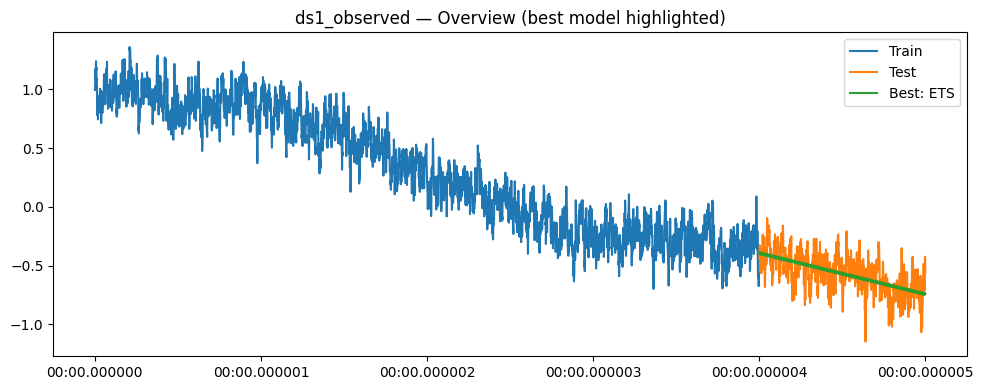

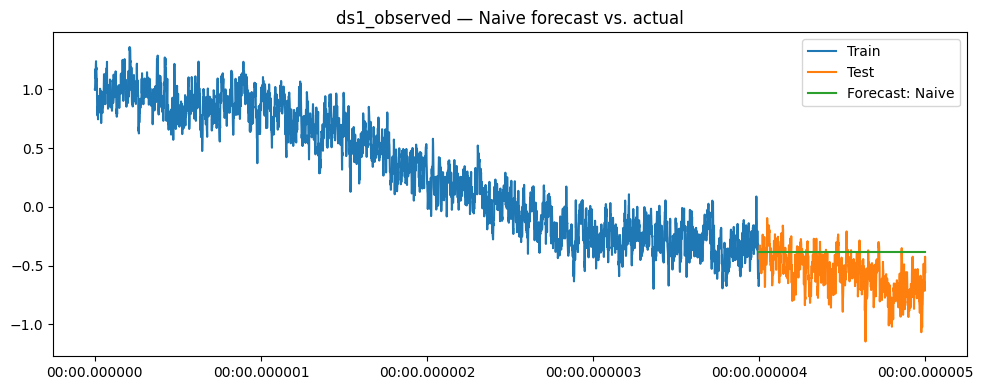

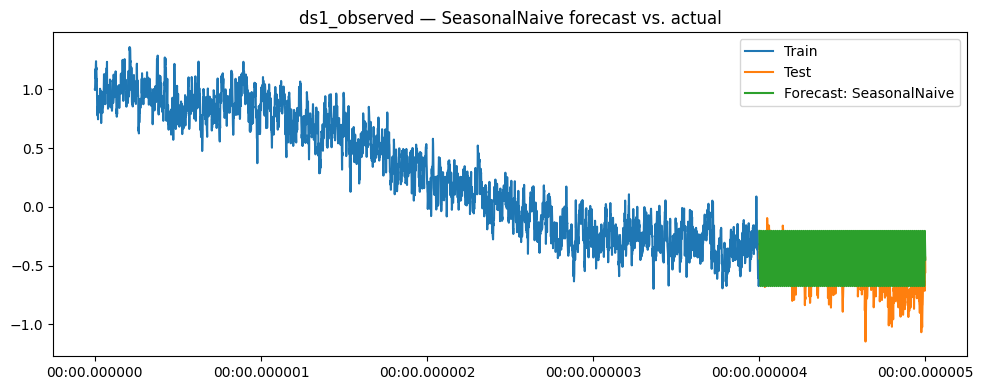

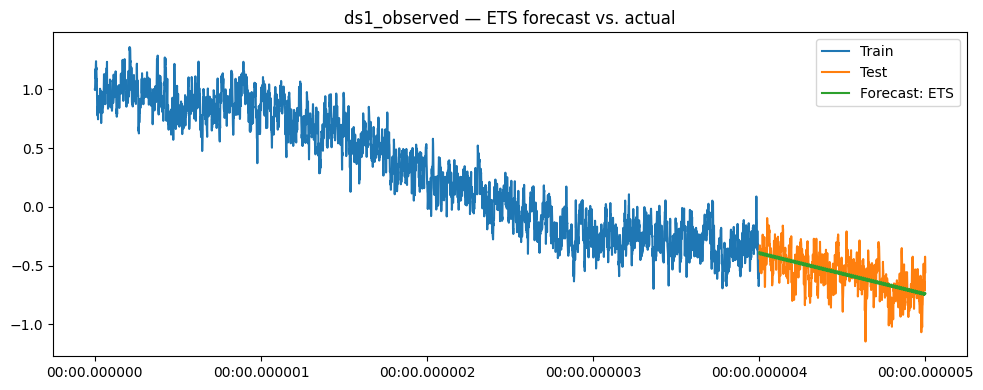

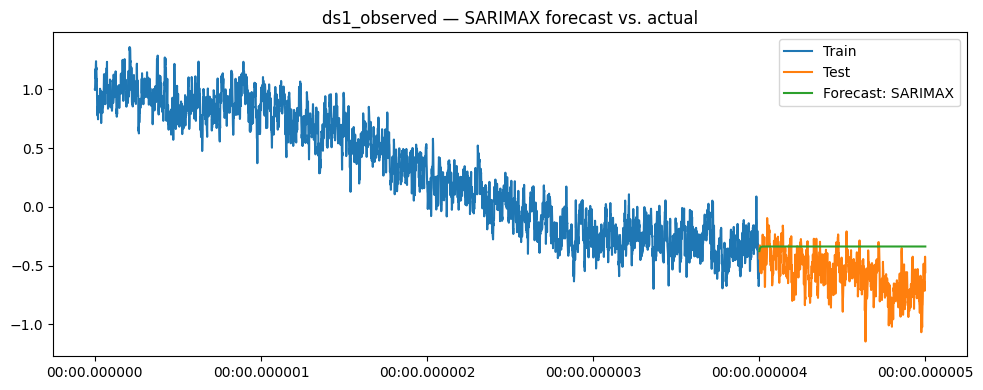

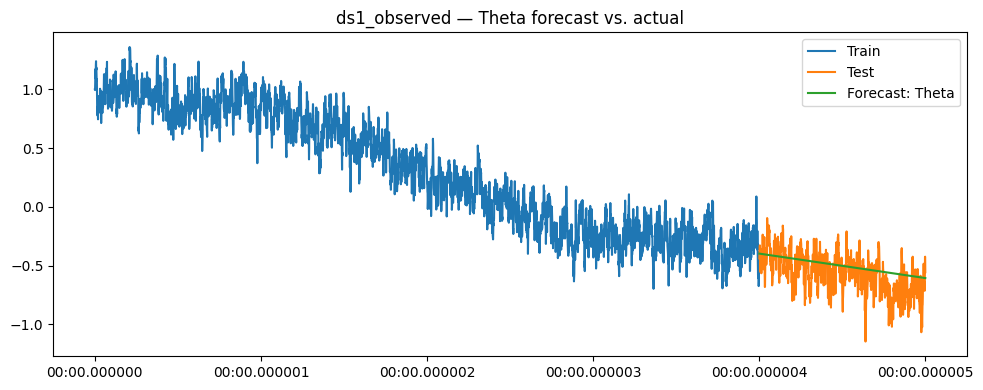


Target series: ds2_observed
Inferred frequency: <Nano>
Seasonal candidates: [12]
Train size: 4000, Test size: 1000
TBATS not available (install error).

Performance (lower is better):
Naive          | sMAPE=13.74%  MAPE=14.44%  RMSE=0.1458
Theta          | sMAPE=13.76%  MAPE=14.18%  RMSE=0.1467
ETS            | sMAPE=14.12%  MAPE=14.13%  RMSE=0.1503
SARIMAX        | sMAPE=14.13%  MAPE=14.10%  RMSE=0.1507
SeasonalNaive  | sMAPE=18.19%  MAPE=17.67%  RMSE=0.187


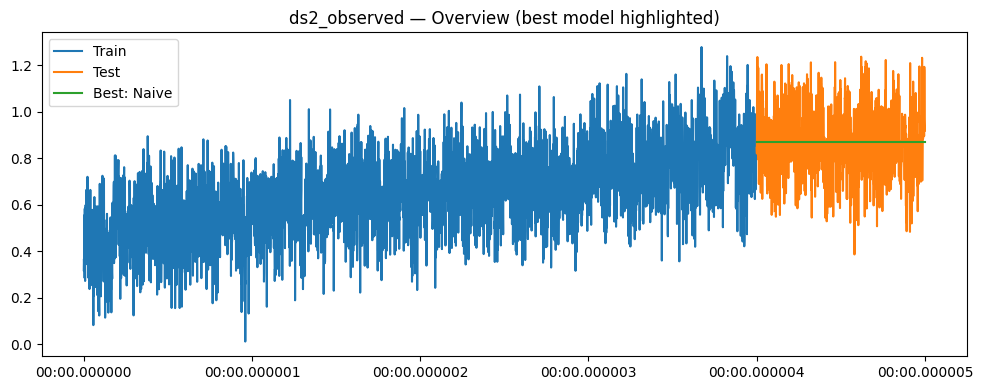

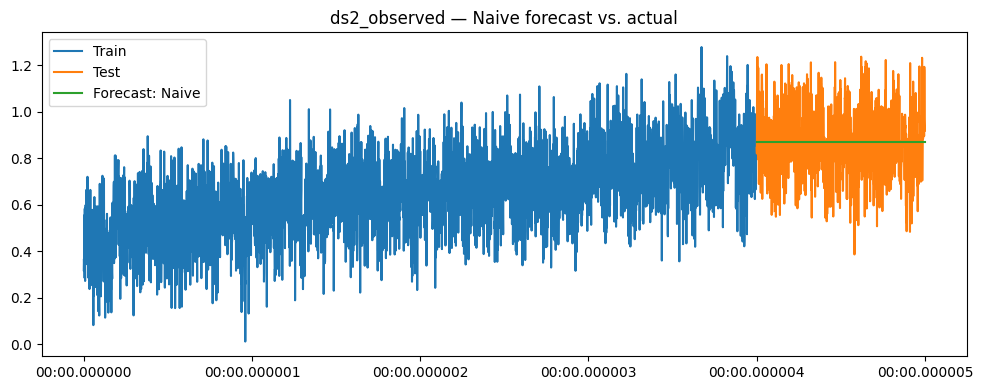

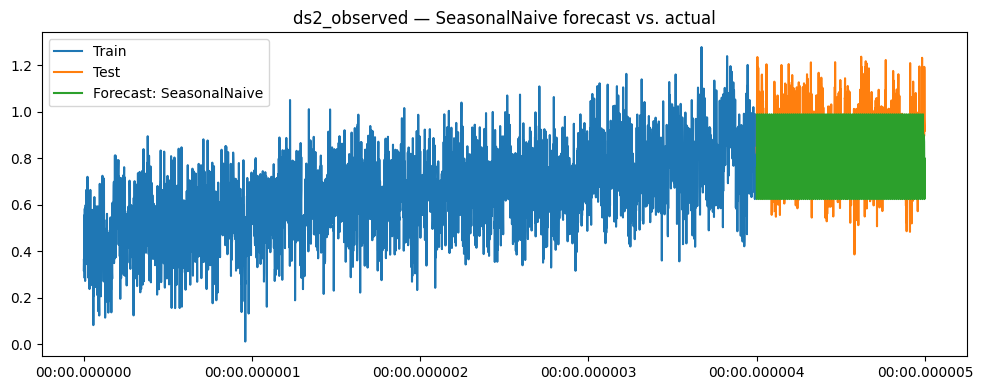

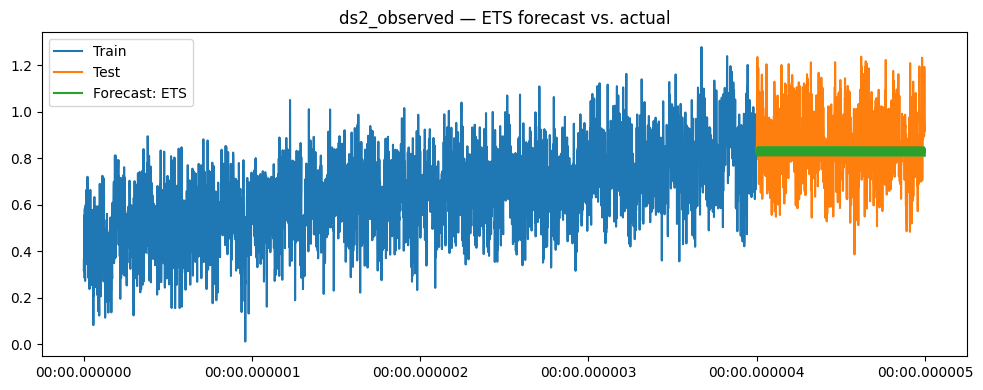

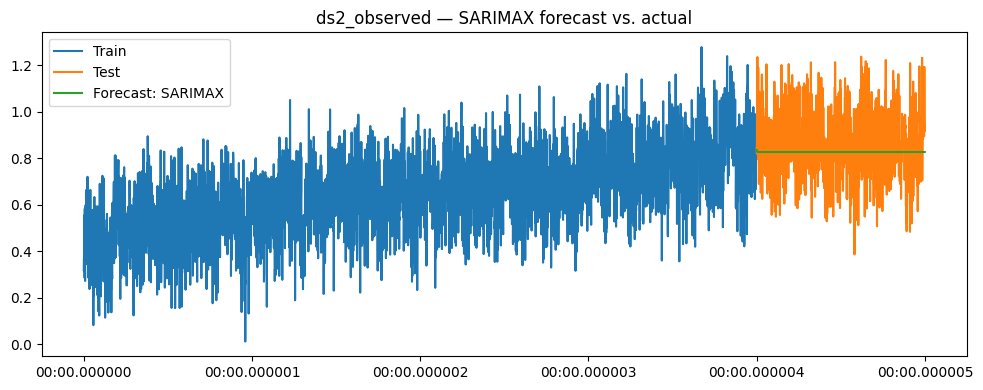

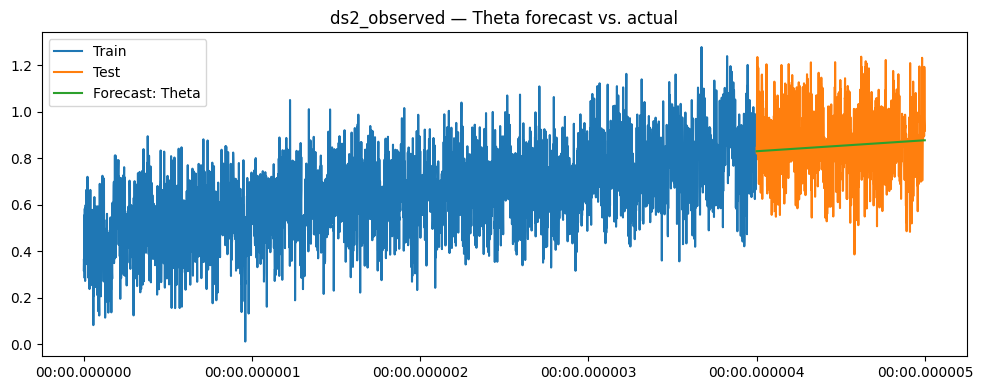


Target series: ds3_observed
Inferred frequency: <Nano>
Seasonal candidates: [12]
Train size: 4000, Test size: 1000
TBATS not available (install error).

Performance (lower is better):
Theta          | sMAPE=72.49%  MAPE=493.46%  RMSE=0.2138
SARIMAX        | sMAPE=78.10%  MAPE=583.38%  RMSE=0.249
Naive          | sMAPE=79.65%  MAPE=599.16%  RMSE=0.2573
SeasonalNaive  | sMAPE=82.15%  MAPE=555.49%  RMSE=0.3006
ETS            | sMAPE=82.53%  MAPE=626.56%  RMSE=0.2735


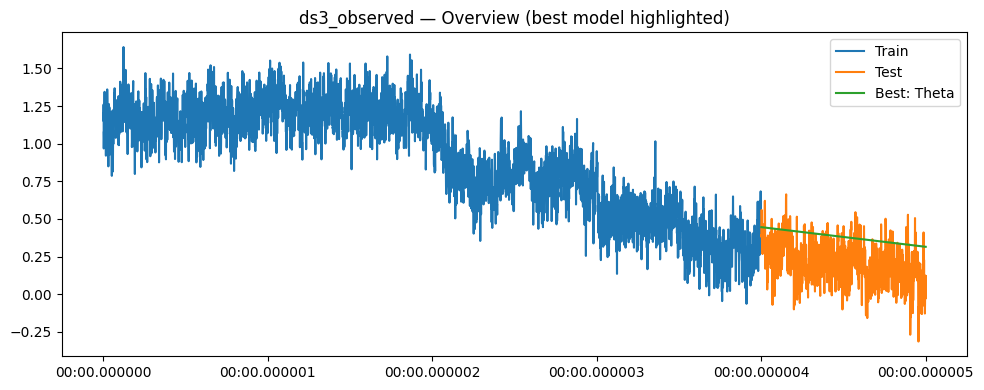

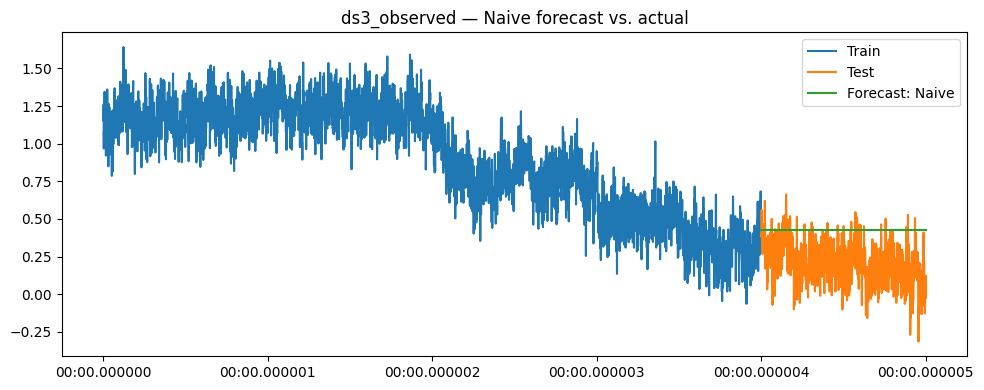

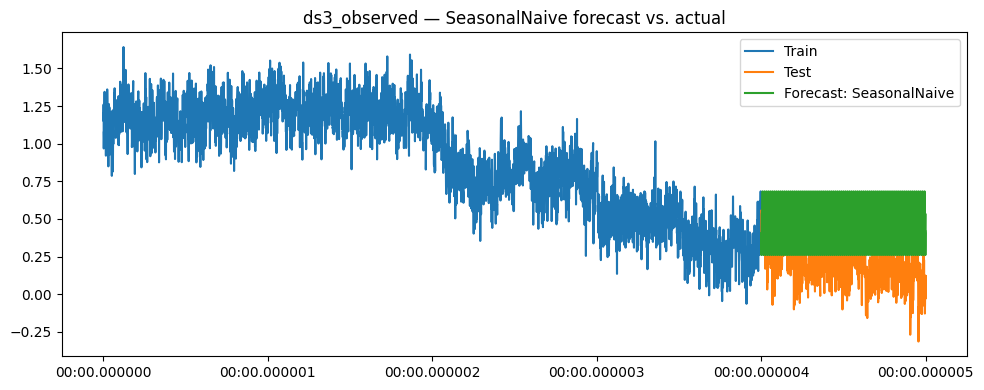

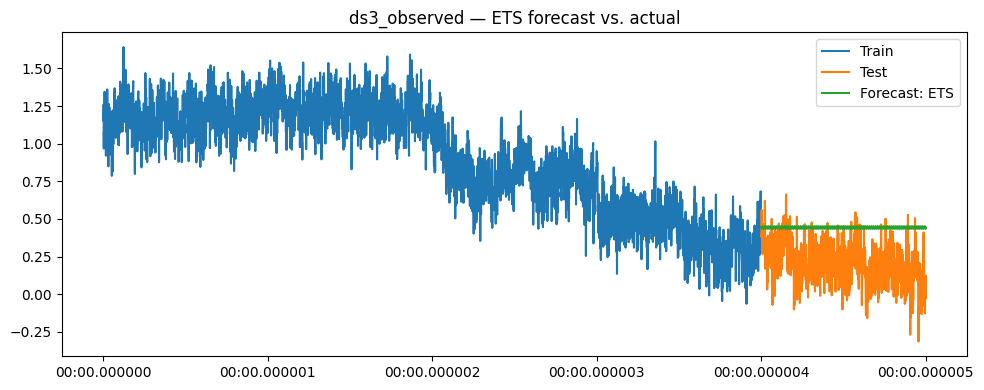

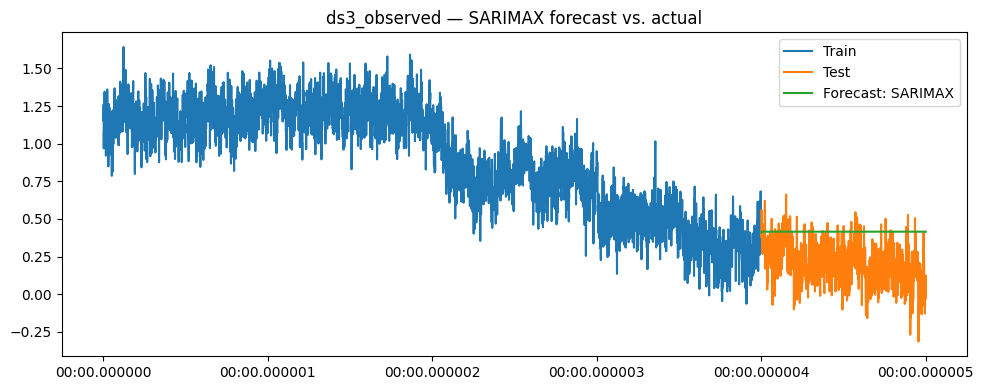

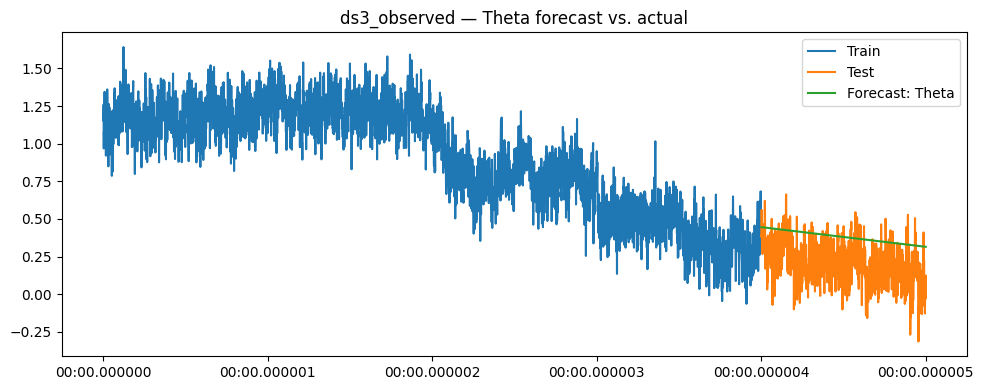


Done. If seasonality looks off, set MANUAL_SEASONAL_PERIODS (e.g., [24, 24*7] or [7, 30] or [12]) and re-run.


In [ ]:
# %% [colab] --- Setup: installs (safe to re-run) ---
!pip -q install tbats --progress-bar off

# %% [colab] --- Imports ---
import warnings, math, sys, itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from google.colab import files

# Statsmodels
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Optional multi-seasonal model
try:
    from tbats import TBATS
    _TBATS_AVAILABLE = True
except Exception:
    _TBATS_AVAILABLE = False

# %% [colab] --- User-adjustable switches ---
MANUAL_SEASONAL_PERIODS = [12] # e.g., [24, 24*7] or [7, 30] or [12]
ENABLE_TBATS = True
TEST_SIZE_RATIO = 0.2
MAX_ETS_SECONDS = 30
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)

# %% [colab] --- Upload CSV ---
print("Please upload your CSV (first column = time).")
uploaded = files.upload()
assert uploaded, "No file uploaded."
csv_path = list(uploaded.keys())[0]
print(f"Loaded: {csv_path}")

# %% [colab] --- Read CSV robustly ---
def read_csv_flex(path):
    for sep in [",",";","\t","|"]:
        try:
            df = pd.read_csv(path, sep=sep, engine="python")
            if df.shape[1] >= 2:
                return df
        except: pass
    return pd.read_csv(path)

raw = read_csv_flex(csv_path)
time_col = raw.columns[0]
df = raw.copy()
df[time_col] = pd.to_datetime(df[time_col], errors="coerce", infer_datetime_format=True)
if df[time_col].isna().all():
    raise ValueError("First column couldn't be parsed as datetime.")
df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)
num_cols = [c for c in df.columns if c != time_col and pd.api.types.is_numeric_dtype(df[c])]
if not num_cols:
    raise ValueError("No numeric columns found apart from the first time column.")
print(f"Detected time column: {time_col}")
print(f"Numeric target columns: {num_cols}")
df = df.set_index(time_col)

# %% [colab] --- Frequency inference & regularization ---
def infer_uniform_freq(idx):
    f = pd.infer_freq(idx)
    if f: return f
    if len(idx) < 3: return None
    diffs = (idx[1:] - idx[:-1]).value_counts()
    if len(diffs)==0: return None
    mode_delta = diffs.index[0]
    secs = int(mode_delta / np.timedelta64(1, 's'))
    if secs <= 0: return None
    if secs % (24*3600) == 0:
        d = secs // (24*3600); return f"{d}D" if d!=1 else "D"
    if secs % 3600 == 0:
        h = secs // 3600; return f"{h}H" if h!=1 else "H"
    if secs % 60 == 0:
        m = secs // 60; return f"{m}T" if m!=1 else "T"
    return f"{secs}S" if secs!=1 else "S"

def as_uniform_series(s: pd.Series):
    s = s.dropna()
    s = s[~s.index.duplicated(keep="first")]
    freq = infer_uniform_freq(s.index)
    if freq is None:
        if len(s.index) < 3: return s, None
        diffs = np.diff(s.index.view(np.int64))
        step = int(np.median(diffs))
        new_index = pd.date_range(s.index.min(), s.index.max(), freq=pd.to_timedelta(step, unit="ns"))
        s = s.reindex(new_index).interpolate(limit_direction="both")
        return s.asfreq(s.index.freq), s.index.freq
    else:
        s = s.asfreq(freq)
        if s.isna().any():
            s = s.interpolate(limit_direction="both")
        return s, s.index.freq

def default_seasonal_candidates(freq_str):
    if freq_str is None: return []
    f = str(freq_str).upper()
    if f.endswith('H') or f=='H': return [24, 24*7]          # hourly: daily + weekly
    if f.endswith('T') or 'MIN' in f: return [60, 60*24, 60*24*7]
    if f.endswith('S') or f=='S': return [60, 3600, 86400]
    if 'D' in f: return [7, 30]
    if 'W' in f: return [52]
    if f.startswith('M'): return [12]
    if f.startswith('Q'): return [4]
    return []

def strictly_positive(x): return np.all(np.asarray(x) > 0)

# %% [colab] --- Metrics ---
def smape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    denom = (np.abs(y) + np.abs(yhat)); denom[denom==0]=1e-9
    return 100*np.mean(2*np.abs(yhat-y)/denom)
def mape(y, yhat):
    y = np.asarray(y); y = np.where(y==0, 1e-9, y)
    return 100*np.mean(np.abs((y - np.asarray(yhat))/y))
def rmse(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    return np.sqrt(np.mean((yhat-y)**2))

# %% [colab] --- ETS / SARIMAX / Theta / TBATS helpers ---
from time import time

def fit_ets(y_train, seasonal_period):
    trend_opts = [None, 'add', 'mul']
    seasonal_opts = [None] if not seasonal_period or seasonal_period<2 else ['add','mul']
    best_aic, best_model = np.inf, None
    t0 = time()
    for tr in trend_opts:
        for se in seasonal_opts:
            if time()-t0 > MAX_ETS_SECONDS: break
            if (tr=='mul' or se=='mul') and not strictly_positive(y_train):
                continue
            try:
                m = ExponentialSmoothing(
                    y_train, trend=tr, seasonal=se,
                    seasonal_periods=(seasonal_period if se else None),
                    initialization_method="estimated"
                ).fit(optimized=True, use_brute=False)
                aic = getattr(m, "aic", np.inf)
                if aic < best_aic: best_aic, best_model = aic, m
            except: pass
    return best_model

def _candidate_sarimax_orders(s_period):
    """Small, fast grid."""
    orders = [(0,0,0),(1,0,0),(0,1,1),(1,1,1),(2,1,1)]
    seas_orders = [(0,0,0,0)]
    if s_period and s_period>=2:
        seas_orders = [(0,0,0,s_period),(1,0,0,s_period),(0,1,1,s_period),(1,1,1,s_period)]
    return orders, seas_orders

def fit_sarimax_best(y_train, s_period):
    best_aic, best_model = np.inf, None
    orders, seas = _candidate_sarimax_orders(s_period)
    for (p,d,q) in orders:
        for (P,D,Q,m) in seas:
            try:
                model = SARIMAX(
                    y_train, order=(p,d,q),
                    seasonal_order=(P,D,Q,m),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)
                aic = model.aic
                if aic < best_aic:
                    best_aic, best_model = aic, model
            except:
                continue
    return best_model

def fit_theta(y_train):
    try: return ThetaModel(y_train, deseasonalize=False).fit()
    except: return None

def fit_tbats(y_train, seasonal_periods_list):
    if not (_TBATS_AVAILABLE and ENABLE_TBATS): return None
    if not seasonal_periods_list or len(seasonal_periods_list)<2: return None
    try:
        est = TBATS(
            seasonal_periods=seasonal_periods_list,
            use_box_cox=False, use_trend=True, use_damped_trend=True,
            use_arma_errors=False, n_jobs=1
        )
        return est.fit(y_train)
    except: return None

# %% [colab] --- Main loop over each numeric series ---
all_results = []

for col in num_cols:
    print("\n" + "="*90)
    print(f"Target series: {col}")
    y_raw = df[col].astype(float).copy()
    y, freq = as_uniform_series(y_raw)
    print(f"Inferred frequency: {freq}")

    # Seasonality candidates
    candidates = MANUAL_SEASONAL_PERIODS if MANUAL_SEASONAL_PERIODS else default_seasonal_candidates(freq)
    print("Seasonal candidates:", candidates if candidates else "None")
    s_period = int(candidates[0]) if candidates else None

    # Split
    n = len(y); h = max(1, int(round(TEST_SIZE_RATIO*n)))
    y_train, y_test = y.iloc[:-h], y.iloc[-h:]
    print(f"Train size: {len(y_train)}, Test size: {h}")

    forecasts, metrics = {}, {}

    # Baselines
    forecasts["Naive"] = pd.Series(np.full(h, y_train.iloc[-1]), index=y_test.index)
    if s_period and len(y_train)>s_period:
        base = y_train.iloc[-s_period:].values
        forecasts["SeasonalNaive"] = pd.Series(np.resize(base, h), index=y_test.index)

    # ETS
    ets_model = fit_ets(y_train, s_period)
    if ets_model is not None:
        try:
            forecasts["ETS"] = pd.Series(ets_model.forecast(h), index=y_test.index)
        except: pass
    else:
        print("ETS skipped.")

    # SARIMAX (replacement for pmdarima)
    sarimax_model = fit_sarimax_best(y_train, s_period)
    if sarimax_model is not None:
        try:
            forecasts["SARIMAX"] = pd.Series(sarimax_model.forecast(steps=h), index=y_test.index)
        except: pass
    else:
        print("SARIMAX skipped (no viable order found).")

    # Theta
    theta_model = fit_theta(y_train)
    if theta_model is not None:
        try:
            forecasts["Theta"] = pd.Series(theta_model.forecast(h), index=y_test.index)
        except: pass

    # TBATS (multi-seasonal)
    tbats_model = fit_tbats(y_train, candidates if candidates else [])
    if tbats_model is not None:
        try:
            forecasts["TBATS"] = pd.Series(tbats_model.forecast(steps=h), index=y_test.index)
        except: pass
    elif ENABLE_TBATS and not _TBATS_AVAILABLE:
        print("TBATS not available (install error).")

    # Metrics
    for name, yhat in forecasts.items():
        metrics[name] = {"sMAPE": smape(y_test, yhat), "MAPE": mape(y_test, yhat), "RMSE": rmse(y_test, yhat)}
    leaderboard = sorted(metrics.items(), key=lambda kv: kv[1]["sMAPE"])
    print("\nPerformance (lower is better):")
    for name, m in leaderboard:
        print(f"{name:<14s} | sMAPE={m['sMAPE']:.2f}%  MAPE={m['MAPE']:.2f}%  RMSE={m['RMSE']:.4g}")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(y_train.index, y_train.values, label="Train")
    plt.plot(y_test.index, y_test.values, label="Test")
    if leaderboard:
        best_name = leaderboard[0][0]
        plt.plot(forecasts[best_name].index, forecasts[best_name].values, label=f"Best: {best_name}")
    plt.title(f"{col} — Overview (best model highlighted)")
    plt.legend(); plt.tight_layout(); plt.show()

    for name, yhat in forecasts.items():
        plt.figure(figsize=(10,4))
        plt.plot(y_train.index, y_train.values, label="Train")
        plt.plot(y_test.index, y_test.values, label="Test")
        plt.plot(yhat.index, yhat.values, label=f"Forecast: {name}")
        plt.title(f"{col} — {name} forecast vs. actual")
        plt.legend(); plt.tight_layout(); plt.show()

    all_results.append({
        "series": col,
        "frequency": str(freq),
        "seasonal_candidates": candidates,
        "seasonal_used": s_period,
        "metrics": metrics
    })

print("\nDone. If seasonality looks off, set MANUAL_SEASONAL_PERIODS (e.g., [24, 24*7] or [7, 30] or [12]) and re-run.")

Please upload your CSV (first column = time).


Saving equipment_degradation_timeseries_forecasting_dataset.csv to equipment_degradation_timeseries_forecasting_dataset (15).csv
Loaded: equipment_degradation_timeseries_forecasting_dataset (15).csv
Detected time column: t
Numeric target columns: ['ds1_observed', 'ds2_observed', 'ds3_observed']

Target series: ds1_observed
Inferred frequency: <Nano>
Seasonal candidates: [7, 30]
Train size: 4000, Test size: 1000
TBATS not available (install error).

Performance (lower is better):
Theta          | sMAPE=22.45%  MAPE=22.52%  RMSE=0.1543
SeasonalNaive  | sMAPE=29.16%  MAPE=31.66%  RMSE=0.1958
ETS            | sMAPE=37.38%  MAPE=31.94%  RMSE=0.2379
Naive          | sMAPE=39.29%  MAPE=33.02%  RMSE=0.2462
SARIMAX        | sMAPE=49.01%  MAPE=38.66%  RMSE=0.284


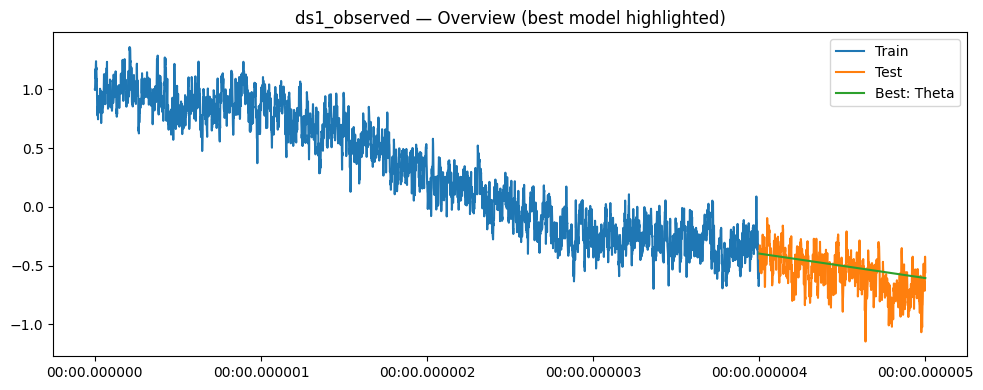

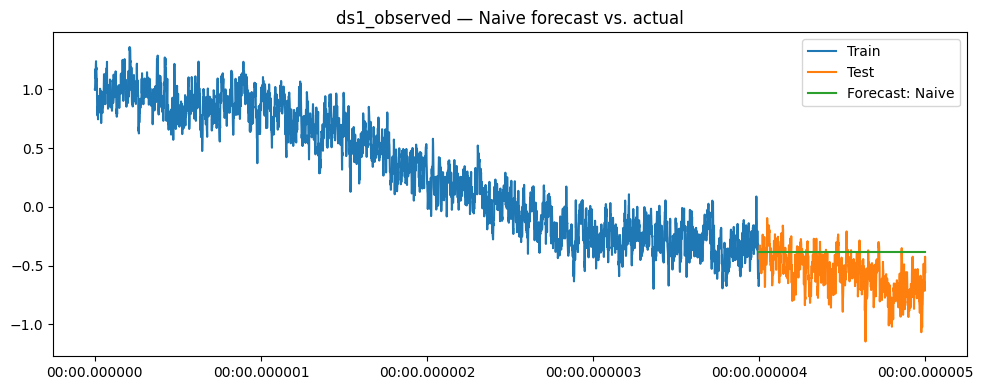

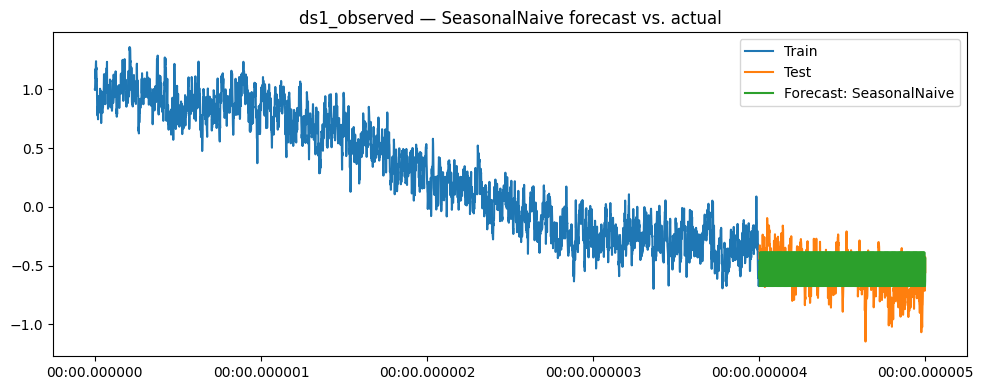

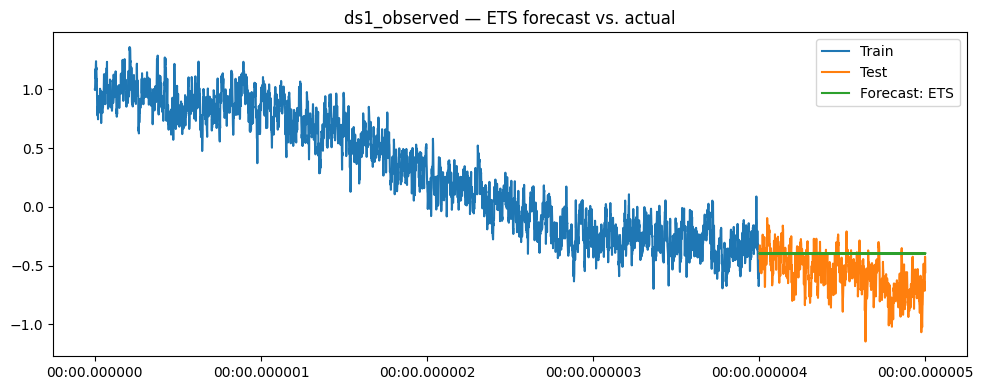

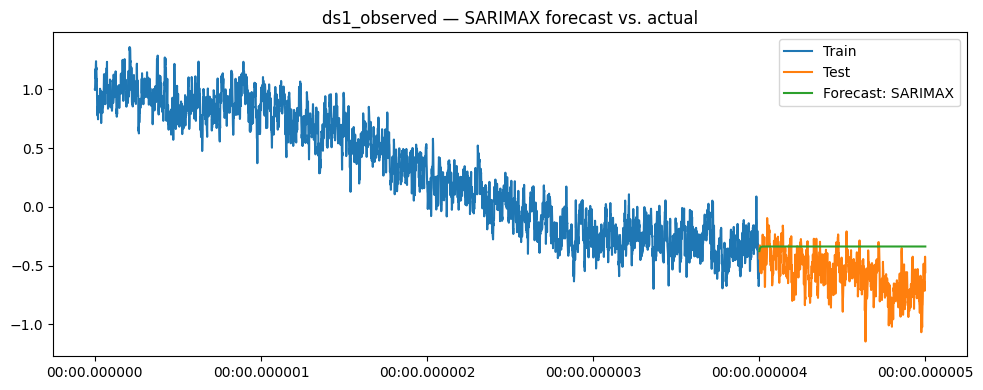

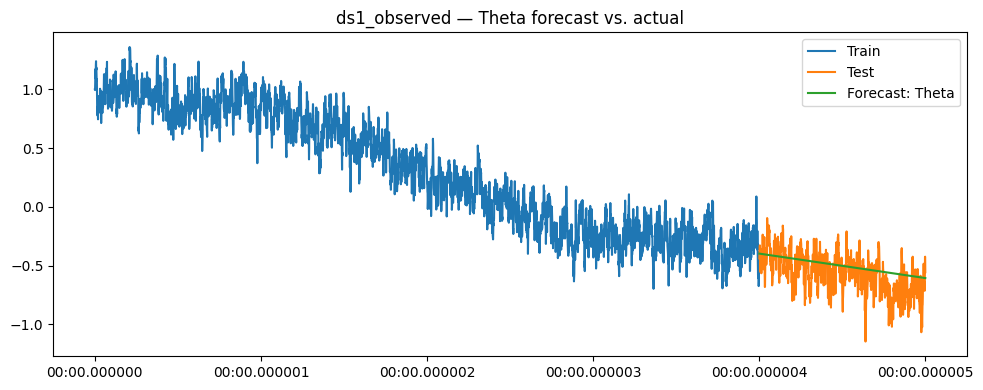


Target series: ds2_observed
Inferred frequency: <Nano>
Seasonal candidates: [7, 30]
Train size: 4000, Test size: 1000
TBATS not available (install error).

Performance (lower is better):
Naive          | sMAPE=13.74%  MAPE=14.44%  RMSE=0.1458
Theta          | sMAPE=13.76%  MAPE=14.18%  RMSE=0.1467
SARIMAX        | sMAPE=14.13%  MAPE=14.10%  RMSE=0.1507
ETS            | sMAPE=14.14%  MAPE=14.13%  RMSE=0.1506
SeasonalNaive  | sMAPE=16.44%  MAPE=16.36%  RMSE=0.1701


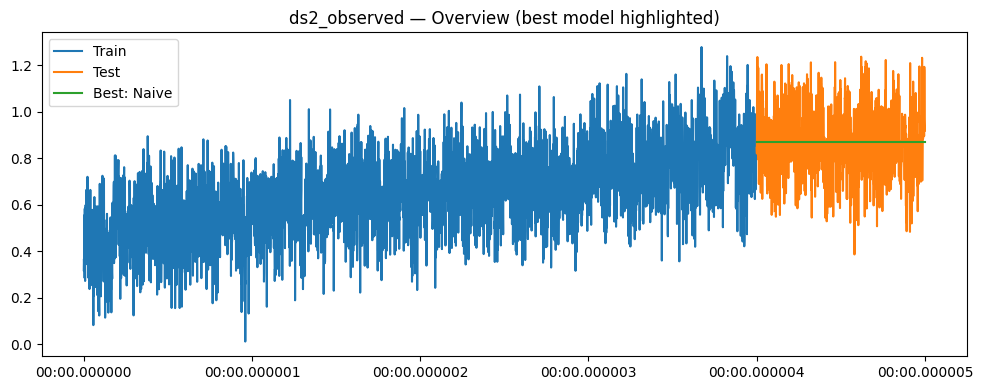

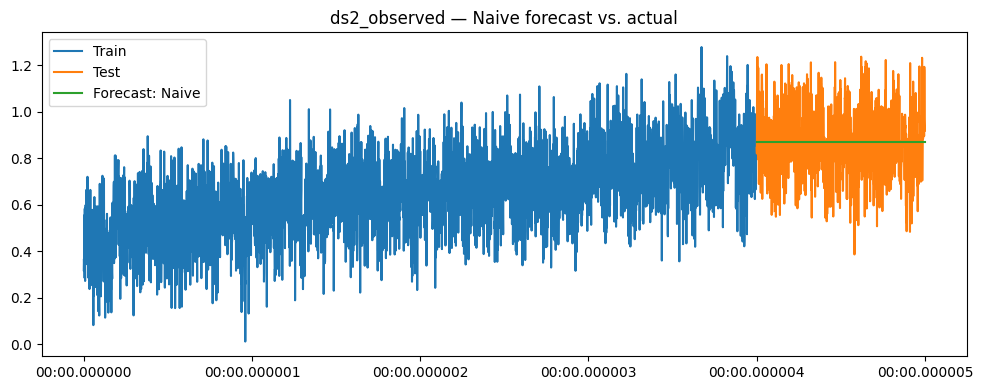

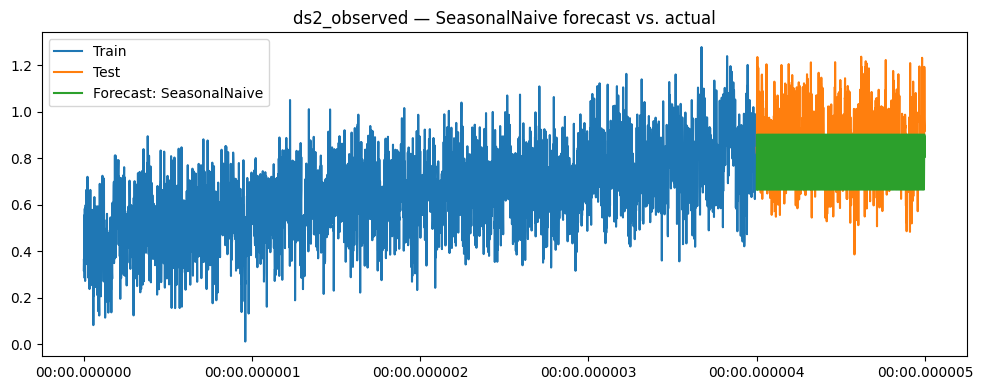

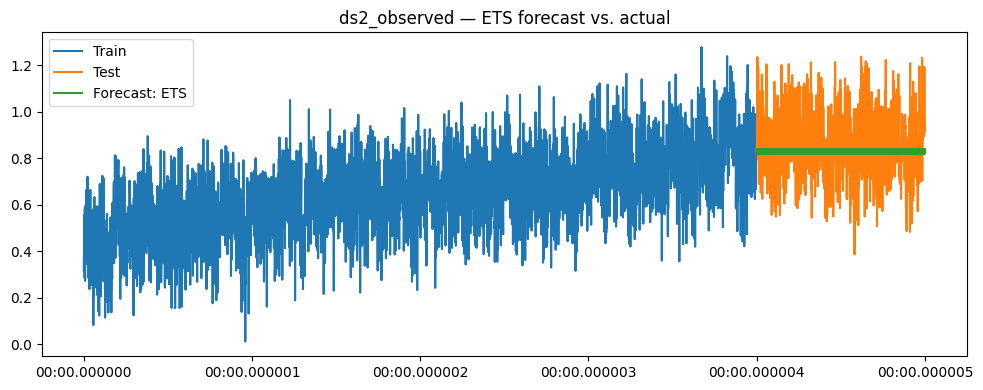

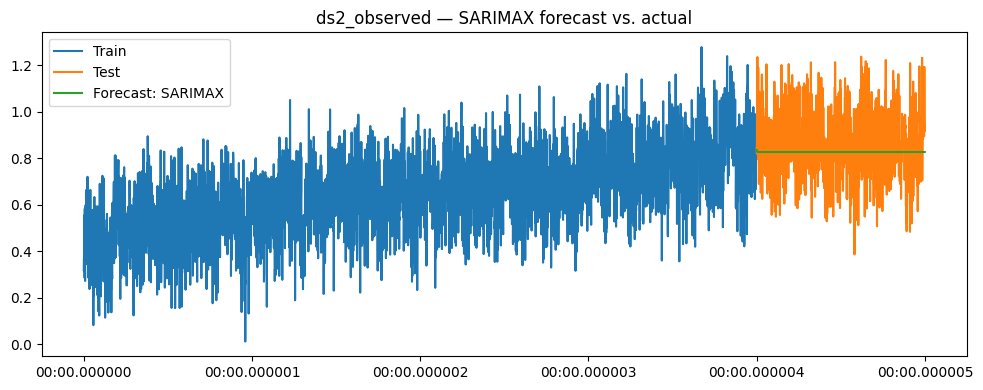

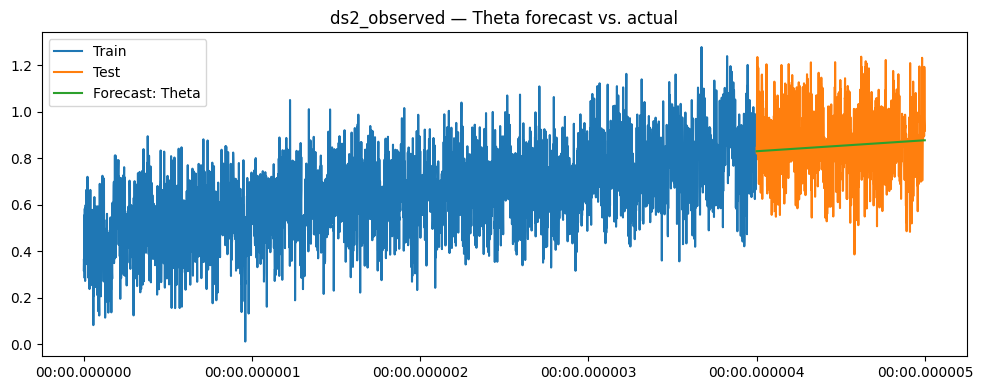


Target series: ds3_observed
Inferred frequency: <Nano>
Seasonal candidates: [7, 30]
Train size: 4000, Test size: 1000
TBATS not available (install error).

Performance (lower is better):
Theta          | sMAPE=72.49%  MAPE=493.46%  RMSE=0.2138
SARIMAX        | sMAPE=78.10%  MAPE=583.38%  RMSE=0.249
Naive          | sMAPE=79.65%  MAPE=599.16%  RMSE=0.2573
ETS            | sMAPE=83.02%  MAPE=635.51%  RMSE=0.2762
SeasonalNaive  | sMAPE=85.89%  MAPE=638.01%  RMSE=0.3246


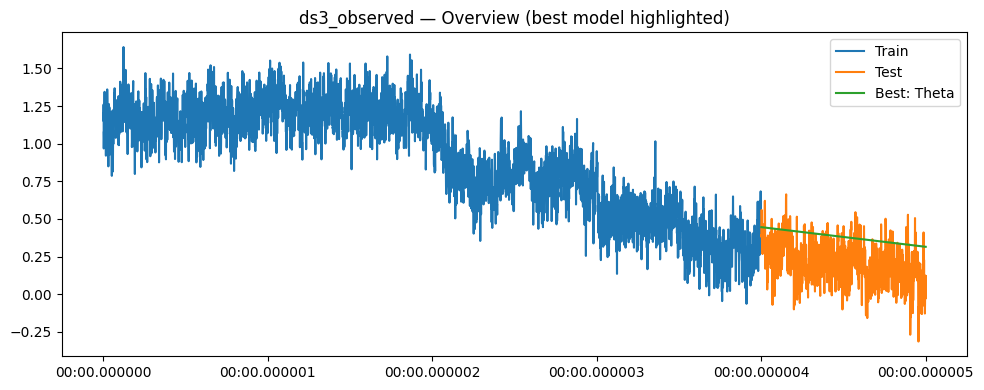

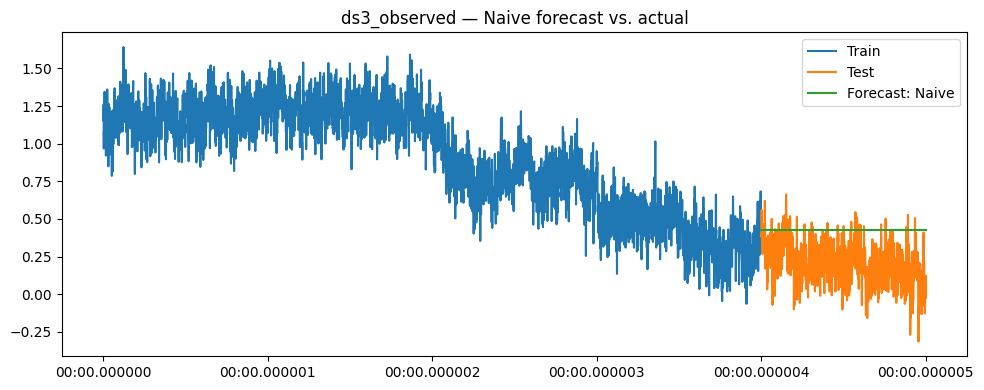

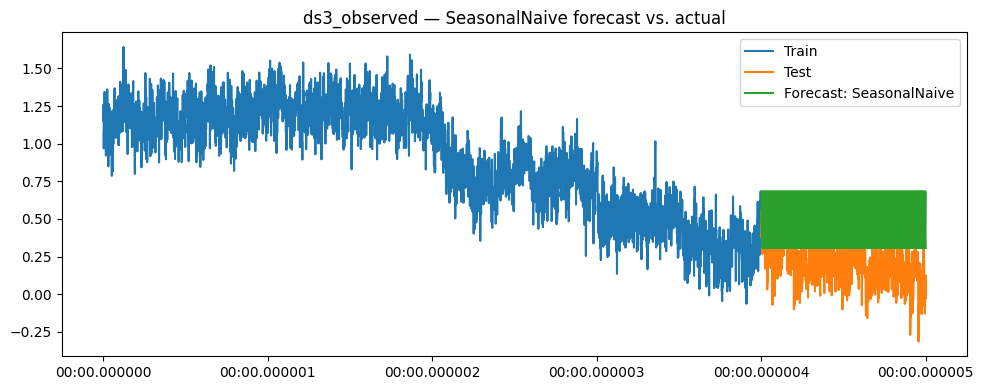

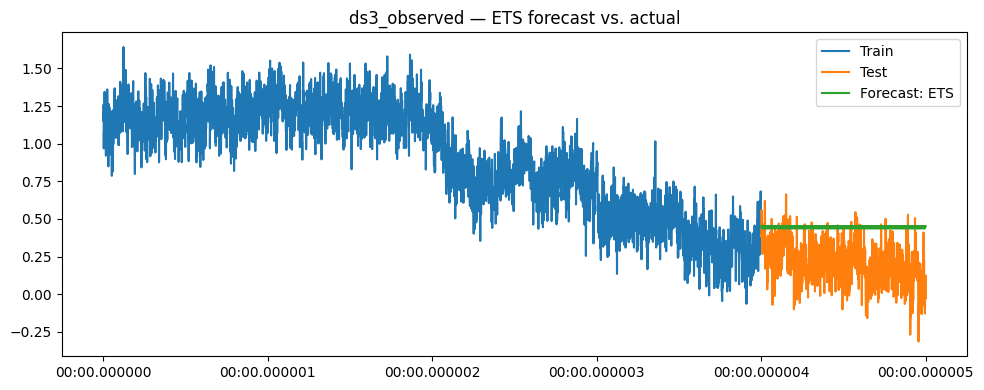

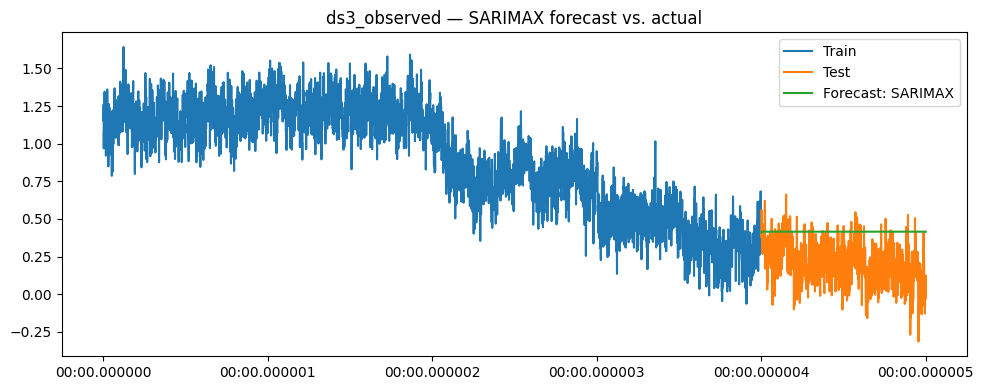

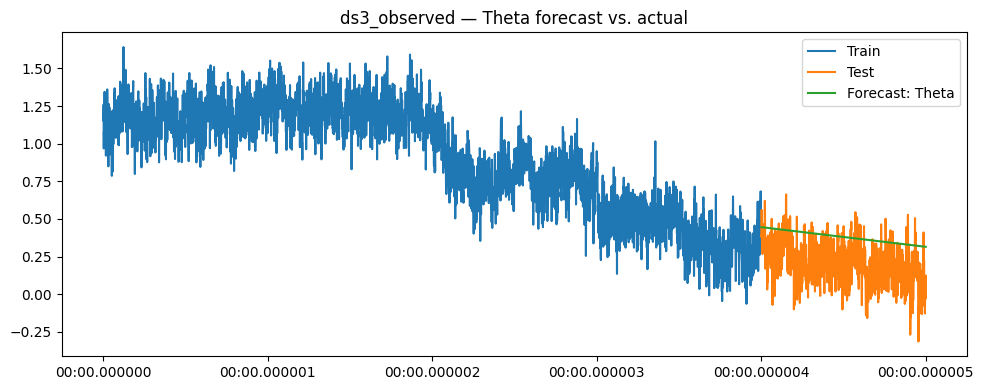


Done. If seasonality looks off, set MANUAL_SEASONAL_PERIODS (e.g., [24, 24*7] or [7, 30] or [12]) and re-run.


In [ ]:
# %% [colab] --- Setup: installs (safe to re-run) ---
!pip -q install tbats --progress-bar off

# %% [colab] --- Imports ---
import warnings, math, sys, itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from google.colab import files

# Statsmodels
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Optional multi-seasonal model
try:
    from tbats import TBATS
    _TBATS_AVAILABLE = True
except Exception:
    _TBATS_AVAILABLE = False

# %% [colab] --- User-adjustable switches ---
MANUAL_SEASONAL_PERIODS = [7, 30] # e.g., [24, 24*7] or [7, 30] or [12]
ENABLE_TBATS = True
TEST_SIZE_RATIO = 0.2
MAX_ETS_SECONDS = 30
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)

# %% [colab] --- Upload CSV ---
print("Please upload your CSV (first column = time).")
uploaded = files.upload()
assert uploaded, "No file uploaded."
csv_path = list(uploaded.keys())[0]
print(f"Loaded: {csv_path}")

# %% [colab] --- Read CSV robustly ---
def read_csv_flex(path):
    for sep in [",",";","\t","|"]:
        try:
            df = pd.read_csv(path, sep=sep, engine="python")
            if df.shape[1] >= 2:
                return df
        except: pass
    return pd.read_csv(path)

raw = read_csv_flex(csv_path)
time_col = raw.columns[0]
df = raw.copy()
df[time_col] = pd.to_datetime(df[time_col], errors="coerce", infer_datetime_format=True)
if df[time_col].isna().all():
    raise ValueError("First column couldn't be parsed as datetime.")
df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)
num_cols = [c for c in df.columns if c != time_col and pd.api.types.is_numeric_dtype(df[c])]
if not num_cols:
    raise ValueError("No numeric columns found apart from the first time column.")
print(f"Detected time column: {time_col}")
print(f"Numeric target columns: {num_cols}")
df = df.set_index(time_col)

# %% [colab] --- Frequency inference & regularization ---
def infer_uniform_freq(idx):
    f = pd.infer_freq(idx)
    if f: return f
    if len(idx) < 3: return None
    diffs = (idx[1:] - idx[:-1]).value_counts()
    if len(diffs)==0: return None
    mode_delta = diffs.index[0]
    secs = int(mode_delta / np.timedelta64(1, 's'))
    if secs <= 0: return None
    if secs % (24*3600) == 0:
        d = secs // (24*3600); return f"{d}D" if d!=1 else "D"
    if secs % 3600 == 0:
        h = secs // 3600; return f"{h}H" if h!=1 else "H"
    if secs % 60 == 0:
        m = secs // 60; return f"{m}T" if m!=1 else "T"
    return f"{secs}S" if secs!=1 else "S"

def as_uniform_series(s: pd.Series):
    s = s.dropna()
    s = s[~s.index.duplicated(keep="first")]
    freq = infer_uniform_freq(s.index)
    if freq is None:
        if len(s.index) < 3: return s, None
        diffs = np.diff(s.index.view(np.int64))
        step = int(np.median(diffs))
        new_index = pd.date_range(s.index.min(), s.index.max(), freq=pd.to_timedelta(step, unit="ns"))
        s = s.reindex(new_index).interpolate(limit_direction="both")
        return s.asfreq(s.index.freq), s.index.freq
    else:
        s = s.asfreq(freq)
        if s.isna().any():
            s = s.interpolate(limit_direction="both")
        return s, s.index.freq

def default_seasonal_candidates(freq_str):
    if freq_str is None: return []
    f = str(freq_str).upper()
    if f.endswith('H') or f=='H': return [24, 24*7]          # hourly: daily + weekly
    if f.endswith('T') or 'MIN' in f: return [60, 60*24, 60*24*7]
    if f.endswith('S') or f=='S': return [60, 3600, 86400]
    if 'D' in f: return [7, 30]
    if 'W' in f: return [52]
    if f.startswith('M'): return [12]
    if f.startswith('Q'): return [4]
    return []

def strictly_positive(x): return np.all(np.asarray(x) > 0)

# %% [colab] --- Metrics ---
def smape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    denom = (np.abs(y) + np.abs(yhat)); denom[denom==0]=1e-9
    return 100*np.mean(2*np.abs(yhat-y)/denom)
def mape(y, yhat):
    y = np.asarray(y); y = np.where(y==0, 1e-9, y)
    return 100*np.mean(np.abs((y - np.asarray(yhat))/y))
def rmse(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    return np.sqrt(np.mean((yhat-y)**2))

# %% [colab] --- ETS / SARIMAX / Theta / TBATS helpers ---
from time import time

def fit_ets(y_train, seasonal_period):
    trend_opts = [None, 'add', 'mul']
    seasonal_opts = [None] if not seasonal_period or seasonal_period<2 else ['add','mul']
    best_aic, best_model = np.inf, None
    t0 = time()
    for tr in trend_opts:
        for se in seasonal_opts:
            if time()-t0 > MAX_ETS_SECONDS: break
            if (tr=='mul' or se=='mul') and not strictly_positive(y_train):
                continue
            try:
                m = ExponentialSmoothing(
                    y_train, trend=tr, seasonal=se,
                    seasonal_periods=(seasonal_period if se else None),
                    initialization_method="estimated"
                ).fit(optimized=True, use_brute=False)
                aic = getattr(m, "aic", np.inf)
                if aic < best_aic: best_aic, best_model = aic, m
            except: pass
    return best_model

def _candidate_sarimax_orders(s_period):
    """Small, fast grid."""
    orders = [(0,0,0),(1,0,0),(0,1,1),(1,1,1),(2,1,1)]
    seas_orders = [(0,0,0,0)]
    if s_period and s_period>=2:
        seas_orders = [(0,0,0,s_period),(1,0,0,s_period),(0,1,1,s_period),(1,1,1,s_period)]
    return orders, seas_orders

def fit_sarimax_best(y_train, s_period):
    best_aic, best_model = np.inf, None
    orders, seas = _candidate_sarimax_orders(s_period)
    for (p,d,q) in orders:
        for (P,D,Q,m) in seas:
            try:
                model = SARIMAX(
                    y_train, order=(p,d,q),
                    seasonal_order=(P,D,Q,m),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)
                aic = model.aic
                if aic < best_aic:
                    best_aic, best_model = aic, model
            except:
                continue
    return best_model

def fit_theta(y_train):
    try: return ThetaModel(y_train, deseasonalize=False).fit()
    except: return None

def fit_tbats(y_train, seasonal_periods_list):
    if not (_TBATS_AVAILABLE and ENABLE_TBATS): return None
    if not seasonal_periods_list or len(seasonal_periods_list)<2: return None
    try:
        est = TBATS(
            seasonal_periods=seasonal_periods_list,
            use_box_cox=False, use_trend=True, use_damped_trend=True,
            use_arma_errors=False, n_jobs=1
        )
        return est.fit(y_train)
    except: return None

# %% [colab] --- Main loop over each numeric series ---
all_results = []

for col in num_cols:
    print("\n" + "="*90)
    print(f"Target series: {col}")
    y_raw = df[col].astype(float).copy()
    y, freq = as_uniform_series(y_raw)
    print(f"Inferred frequency: {freq}")

    # Seasonality candidates
    candidates = MANUAL_SEASONAL_PERIODS if MANUAL_SEASONAL_PERIODS else default_seasonal_candidates(freq)
    print("Seasonal candidates:", candidates if candidates else "None")
    s_period = int(candidates[0]) if candidates else None

    # Split
    n = len(y); h = max(1, int(round(TEST_SIZE_RATIO*n)))
    y_train, y_test = y.iloc[:-h], y.iloc[-h:]
    print(f"Train size: {len(y_train)}, Test size: {h}")

    forecasts, metrics = {}, {}

    # Baselines
    forecasts["Naive"] = pd.Series(np.full(h, y_train.iloc[-1]), index=y_test.index)
    if s_period and len(y_train)>s_period:
        base = y_train.iloc[-s_period:].values
        forecasts["SeasonalNaive"] = pd.Series(np.resize(base, h), index=y_test.index)

    # ETS
    ets_model = fit_ets(y_train, s_period)
    if ets_model is not None:
        try:
            forecasts["ETS"] = pd.Series(ets_model.forecast(h), index=y_test.index)
        except: pass
    else:
        print("ETS skipped.")

    # SARIMAX (replacement for pmdarima)
    sarimax_model = fit_sarimax_best(y_train, s_period)
    if sarimax_model is not None:
        try:
            forecasts["SARIMAX"] = pd.Series(sarimax_model.forecast(steps=h), index=y_test.index)
        except: pass
    else:
        print("SARIMAX skipped (no viable order found).")

    # Theta
    theta_model = fit_theta(y_train)
    if theta_model is not None:
        try:
            forecasts["Theta"] = pd.Series(theta_model.forecast(h), index=y_test.index)
        except: pass

    # TBATS (multi-seasonal)
    tbats_model = fit_tbats(y_train, candidates if candidates else [])
    if tbats_model is not None:
        try:
            forecasts["TBATS"] = pd.Series(tbats_model.forecast(steps=h), index=y_test.index)
        except: pass
    elif ENABLE_TBATS and not _TBATS_AVAILABLE:
        print("TBATS not available (install error).")

    # Metrics
    for name, yhat in forecasts.items():
        metrics[name] = {"sMAPE": smape(y_test, yhat), "MAPE": mape(y_test, yhat), "RMSE": rmse(y_test, yhat)}
    leaderboard = sorted(metrics.items(), key=lambda kv: kv[1]["sMAPE"])
    print("\nPerformance (lower is better):")
    for name, m in leaderboard:
        print(f"{name:<14s} | sMAPE={m['sMAPE']:.2f}%  MAPE={m['MAPE']:.2f}%  RMSE={m['RMSE']:.4g}")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(y_train.index, y_train.values, label="Train")
    plt.plot(y_test.index, y_test.values, label="Test")
    if leaderboard:
        best_name = leaderboard[0][0]
        plt.plot(forecasts[best_name].index, forecasts[best_name].values, label=f"Best: {best_name}")
    plt.title(f"{col} — Overview (best model highlighted)")
    plt.legend(); plt.tight_layout(); plt.show()

    for name, yhat in forecasts.items():
        plt.figure(figsize=(10,4))
        plt.plot(y_train.index, y_train.values, label="Train")
        plt.plot(y_test.index, y_test.values, label="Test")
        plt.plot(yhat.index, yhat.values, label=f"Forecast: {name}")
        plt.title(f"{col} — {name} forecast vs. actual")
        plt.legend(); plt.tight_layout(); plt.show()

    all_results.append({
        "series": col,
        "frequency": str(freq),
        "seasonal_candidates": candidates,
        "seasonal_used": s_period,
        "metrics": metrics
    })

print("\nDone. If seasonality looks off, set MANUAL_SEASONAL_PERIODS (e.g., [24, 24*7] or [7, 30] or [12]) and re-run.")

Please upload your CSV (first column = time).


Saving equipment_degradation_timeseries_forecasting_dataset.csv to equipment_degradation_timeseries_forecasting_dataset (12).csv
Loaded: equipment_degradation_timeseries_forecasting_dataset (12).csv
Detected time column: t
Numeric target columns: ['ds1_observed', 'ds2_observed', 'ds3_observed']

Target series: ds1_observed
Inferred frequency: <Nano>
Seasonal candidates: [24, 168]
Train size: 4000, Test size: 1000
TBATS not available (install error).

Performance (lower is better):
ETS            | sMAPE=20.11%  MAPE=22.69%  RMSE=0.1347
Theta          | sMAPE=22.45%  MAPE=22.52%  RMSE=0.1543
Naive          | sMAPE=39.29%  MAPE=33.02%  RMSE=0.2462
SARIMAX        | sMAPE=49.01%  MAPE=38.66%  RMSE=0.284
SeasonalNaive  | sMAPE=68.03%  MAPE=50.14%  RMSE=0.3443


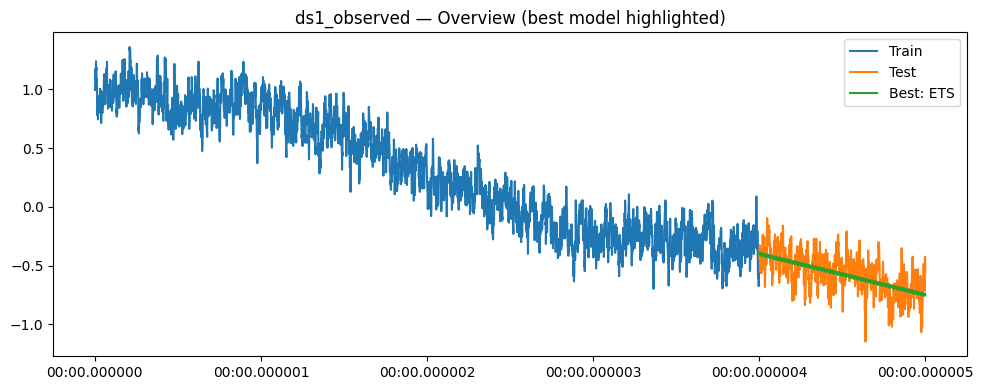

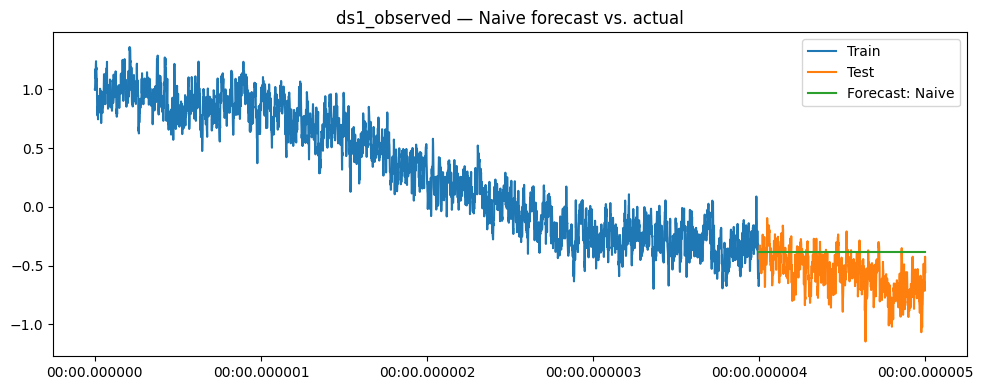

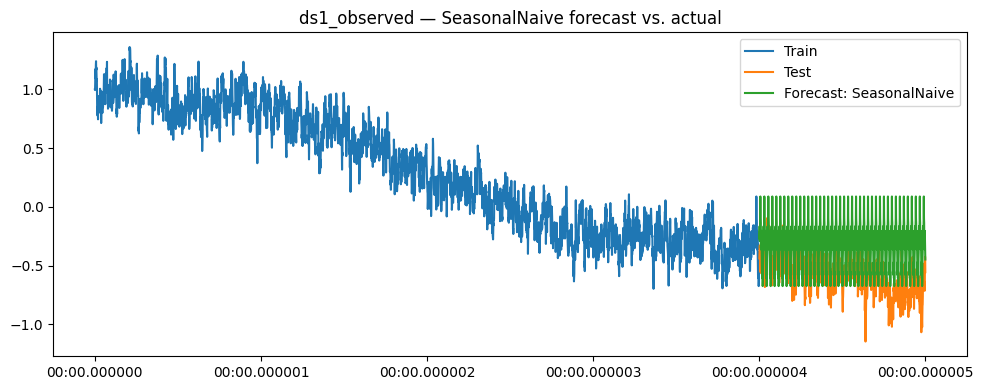

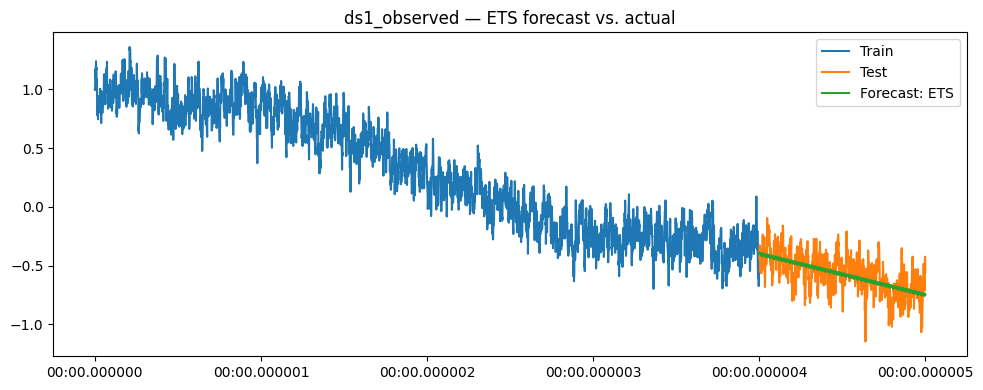

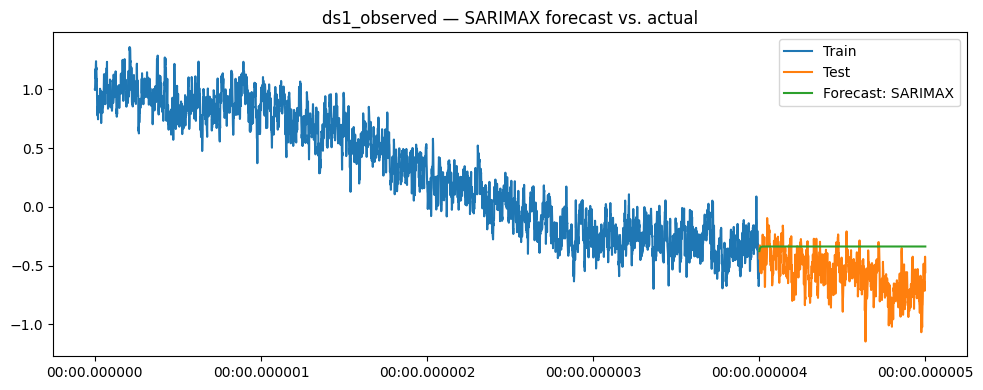

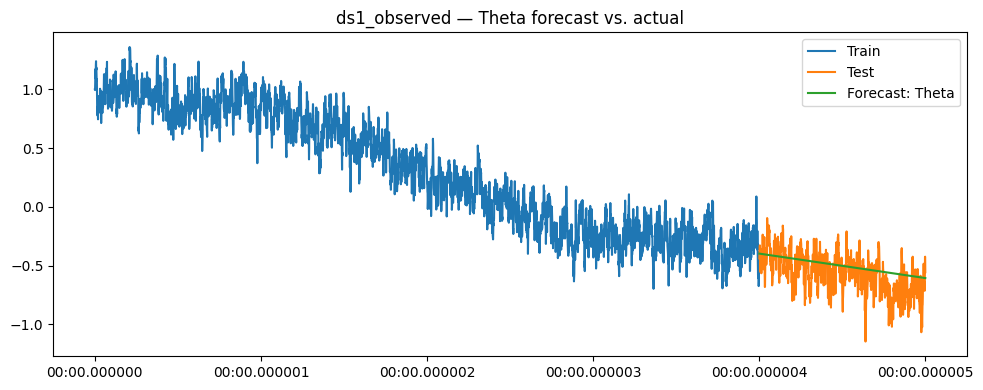


Target series: ds2_observed
Inferred frequency: <Nano>
Seasonal candidates: [24, 168]
Train size: 4000, Test size: 1000
TBATS not available (install error).

Performance (lower is better):
Naive          | sMAPE=13.74%  MAPE=14.44%  RMSE=0.1458
Theta          | sMAPE=13.76%  MAPE=14.18%  RMSE=0.1467
SARIMAX        | sMAPE=14.13%  MAPE=14.10%  RMSE=0.1507
ETS            | sMAPE=14.15%  MAPE=14.15%  RMSE=0.1504
SeasonalNaive  | sMAPE=17.58%  MAPE=17.39%  RMSE=0.1838


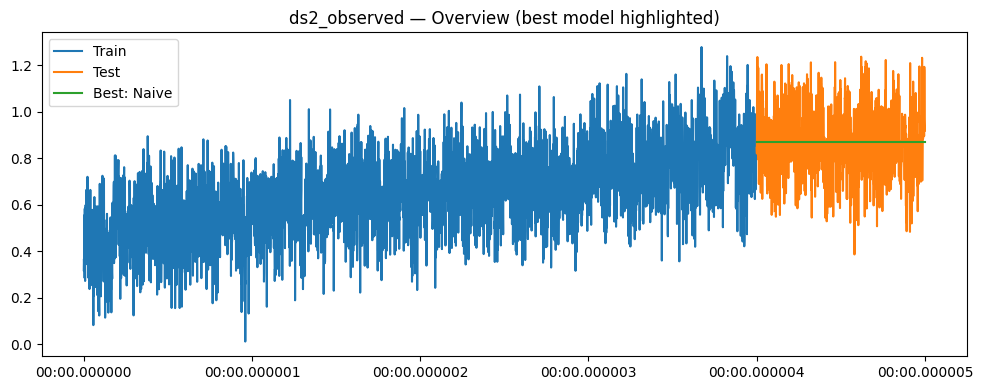

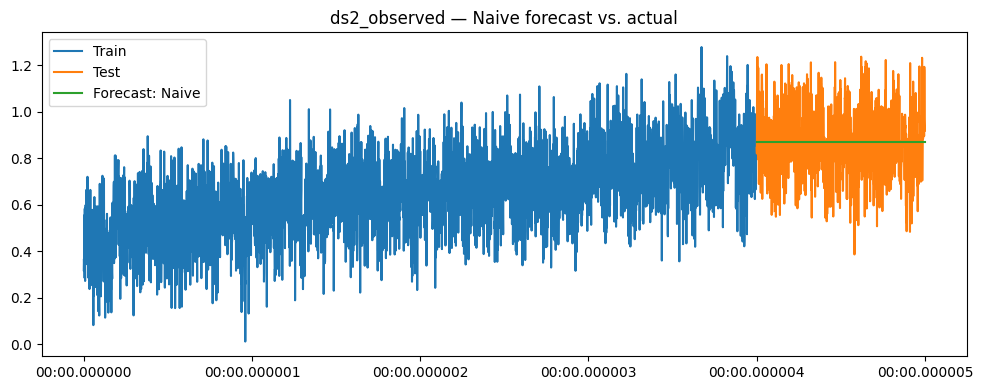

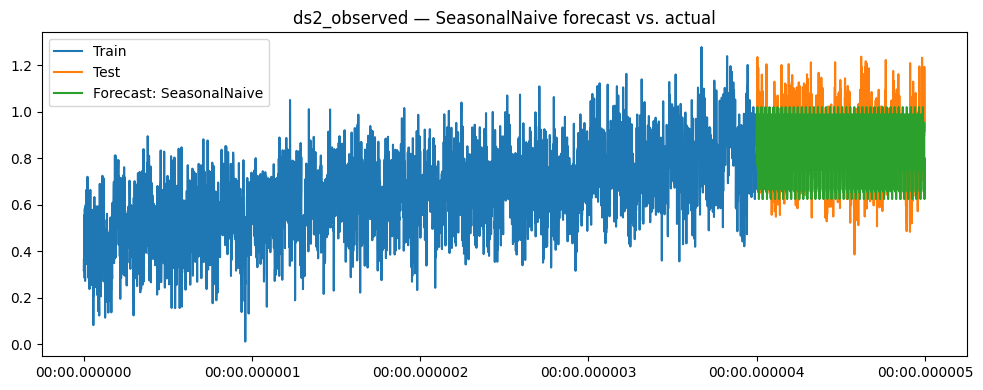

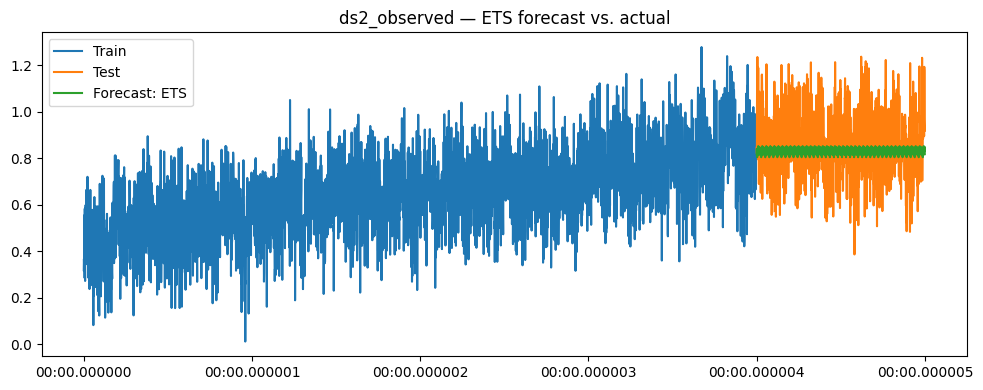

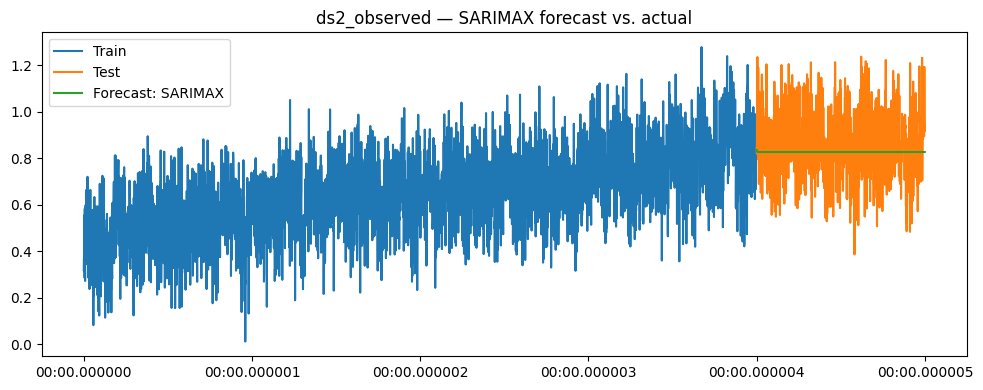

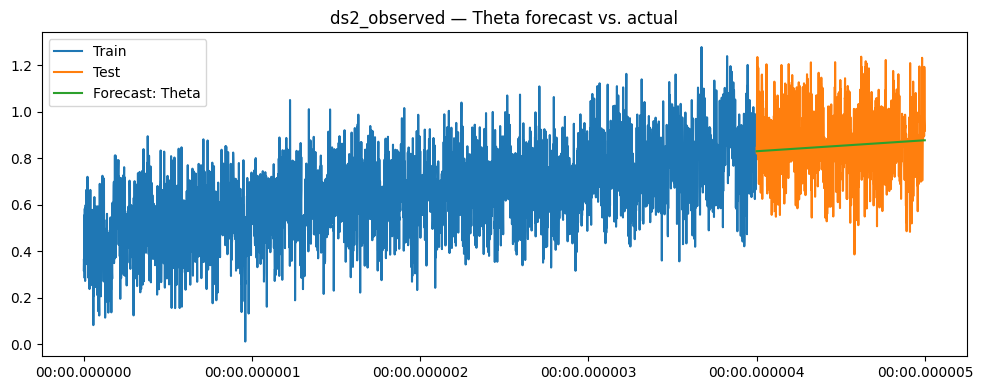


Target series: ds3_observed
Inferred frequency: <Nano>
Seasonal candidates: [24, 168]
Train size: 4000, Test size: 1000
TBATS not available (install error).

Performance (lower is better):
Theta          | sMAPE=72.49%  MAPE=493.46%  RMSE=0.2138
SARIMAX        | sMAPE=78.10%  MAPE=583.38%  RMSE=0.249
SeasonalNaive  | sMAPE=78.78%  MAPE=640.57%  RMSE=0.2837
Naive          | sMAPE=79.65%  MAPE=599.16%  RMSE=0.2573
ETS            | sMAPE=82.28%  MAPE=627.96%  RMSE=0.2721


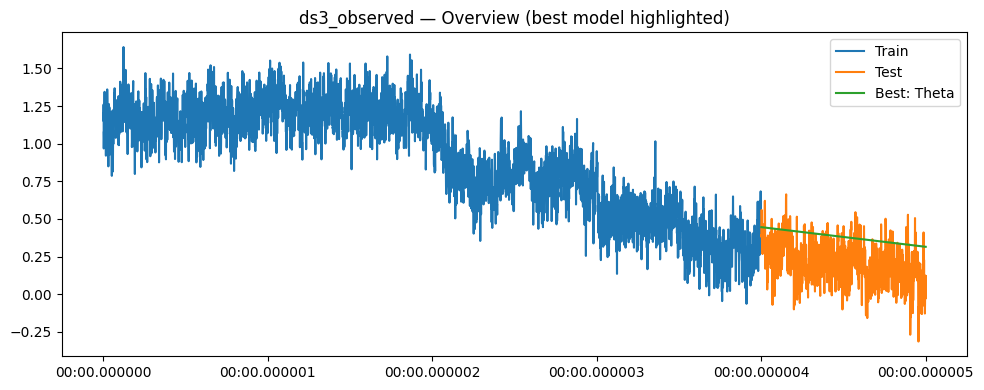

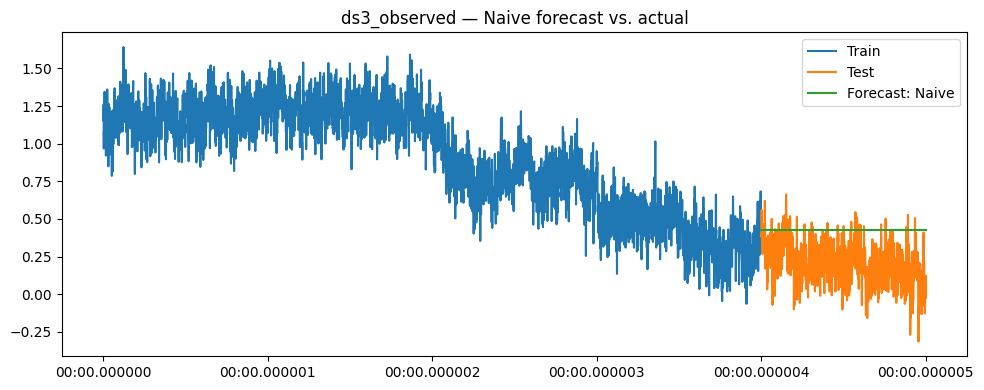

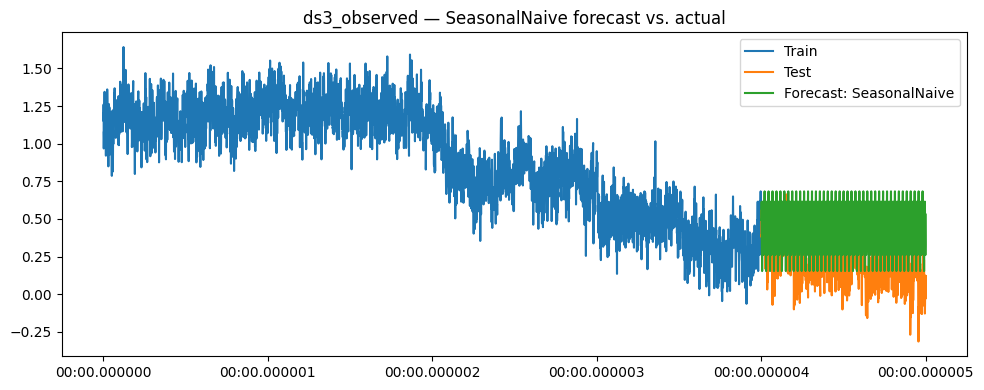

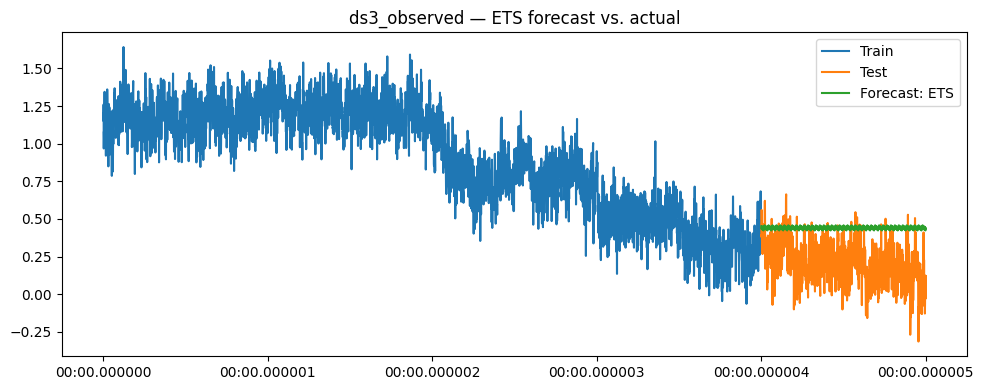

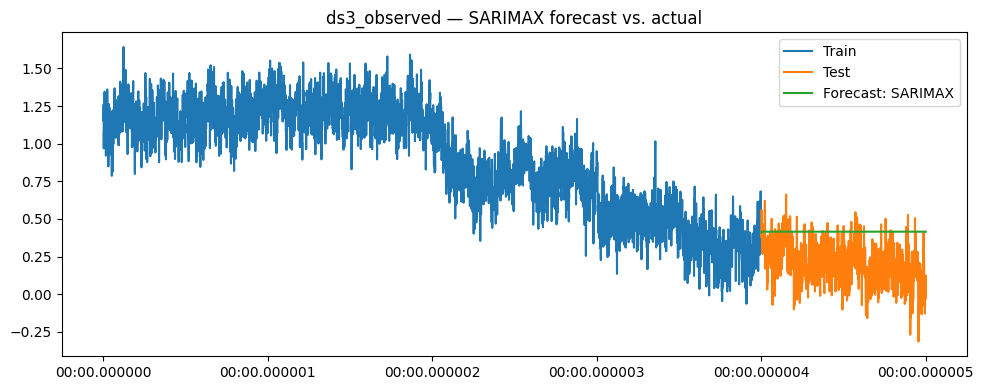

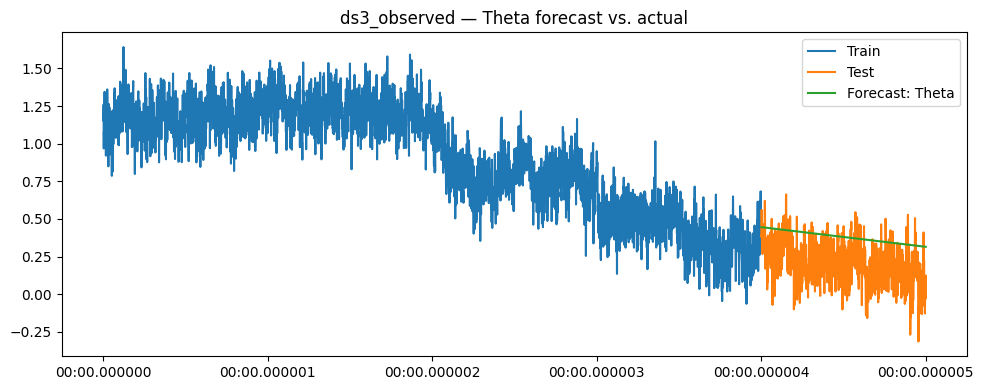


Done. If seasonality looks off, set MANUAL_SEASONAL_PERIODS (e.g., [24, 24*7] or [7, 30] or [12]) and re-run.


In [ ]:
# %% [colab] --- Setup: installs (safe to re-run) ---
!pip -q install tbats --progress-bar off

# %% [colab] --- Imports ---
import warnings, math, sys, itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from google.colab import files

# Statsmodels
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Optional multi-seasonal model
try:
    from tbats import TBATS
    _TBATS_AVAILABLE = True
except Exception:
    _TBATS_AVAILABLE = False

# %% [colab] --- User-adjustable switches ---
MANUAL_SEASONAL_PERIODS = [24, 24*7]  # e.g., [24, 24*7] or [7, 30] or [12]
ENABLE_TBATS = True
TEST_SIZE_RATIO = 0.2
MAX_ETS_SECONDS = 30
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)

# %% [colab] --- Upload CSV ---
print("Please upload your CSV (first column = time).")
uploaded = files.upload()
assert uploaded, "No file uploaded."
csv_path = list(uploaded.keys())[0]
print(f"Loaded: {csv_path}")

# %% [colab] --- Read CSV robustly ---
def read_csv_flex(path):
    for sep in [",",";","\t","|"]:
        try:
            df = pd.read_csv(path, sep=sep, engine="python")
            if df.shape[1] >= 2:
                return df
        except: pass
    return pd.read_csv(path)

raw = read_csv_flex(csv_path)
time_col = raw.columns[0]
df = raw.copy()
df[time_col] = pd.to_datetime(df[time_col], errors="coerce", infer_datetime_format=True)
if df[time_col].isna().all():
    raise ValueError("First column couldn't be parsed as datetime.")
df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)
num_cols = [c for c in df.columns if c != time_col and pd.api.types.is_numeric_dtype(df[c])]
if not num_cols:
    raise ValueError("No numeric columns found apart from the first time column.")
print(f"Detected time column: {time_col}")
print(f"Numeric target columns: {num_cols}")
df = df.set_index(time_col)

# %% [colab] --- Frequency inference & regularization ---
def infer_uniform_freq(idx):
    f = pd.infer_freq(idx)
    if f: return f
    if len(idx) < 3: return None
    diffs = (idx[1:] - idx[:-1]).value_counts()
    if len(diffs)==0: return None
    mode_delta = diffs.index[0]
    secs = int(mode_delta / np.timedelta64(1, 's'))
    if secs <= 0: return None
    if secs % (24*3600) == 0:
        d = secs // (24*3600); return f"{d}D" if d!=1 else "D"
    if secs % 3600 == 0:
        h = secs // 3600; return f"{h}H" if h!=1 else "H"
    if secs % 60 == 0:
        m = secs // 60; return f"{m}T" if m!=1 else "T"
    return f"{secs}S" if secs!=1 else "S"

def as_uniform_series(s: pd.Series):
    s = s.dropna()
    s = s[~s.index.duplicated(keep="first")]
    freq = infer_uniform_freq(s.index)
    if freq is None:
        if len(s.index) < 3: return s, None
        diffs = np.diff(s.index.view(np.int64))
        step = int(np.median(diffs))
        new_index = pd.date_range(s.index.min(), s.index.max(), freq=pd.to_timedelta(step, unit="ns"))
        s = s.reindex(new_index).interpolate(limit_direction="both")
        return s.asfreq(s.index.freq), s.index.freq
    else:
        s = s.asfreq(freq)
        if s.isna().any():
            s = s.interpolate(limit_direction="both")
        return s, s.index.freq

def default_seasonal_candidates(freq_str):
    if freq_str is None: return []
    f = str(freq_str).upper()
    if f.endswith('H') or f=='H': return [24, 24*7]          # hourly: daily + weekly
    if f.endswith('T') or 'MIN' in f: return [60, 60*24, 60*24*7]
    if f.endswith('S') or f=='S': return [60, 3600, 86400]
    if 'D' in f: return [7, 30]
    if 'W' in f: return [52]
    if f.startswith('M'): return [12]
    if f.startswith('Q'): return [4]
    return []

def strictly_positive(x): return np.all(np.asarray(x) > 0)

# %% [colab] --- Metrics ---
def smape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    denom = (np.abs(y) + np.abs(yhat)); denom[denom==0]=1e-9
    return 100*np.mean(2*np.abs(yhat-y)/denom)
def mape(y, yhat):
    y = np.asarray(y); y = np.where(y==0, 1e-9, y)
    return 100*np.mean(np.abs((y - np.asarray(yhat))/y))
def rmse(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    return np.sqrt(np.mean((yhat-y)**2))

# %% [colab] --- ETS / SARIMAX / Theta / TBATS helpers ---
from time import time

def fit_ets(y_train, seasonal_period):
    trend_opts = [None, 'add', 'mul']
    seasonal_opts = [None] if not seasonal_period or seasonal_period<2 else ['add','mul']
    best_aic, best_model = np.inf, None
    t0 = time()
    for tr in trend_opts:
        for se in seasonal_opts:
            if time()-t0 > MAX_ETS_SECONDS: break
            if (tr=='mul' or se=='mul') and not strictly_positive(y_train):
                continue
            try:
                m = ExponentialSmoothing(
                    y_train, trend=tr, seasonal=se,
                    seasonal_periods=(seasonal_period if se else None),
                    initialization_method="estimated"
                ).fit(optimized=True, use_brute=False)
                aic = getattr(m, "aic", np.inf)
                if aic < best_aic: best_aic, best_model = aic, m
            except: pass
    return best_model

def _candidate_sarimax_orders(s_period):
    """Small, fast grid."""
    orders = [(0,0,0),(1,0,0),(0,1,1),(1,1,1),(2,1,1)]
    seas_orders = [(0,0,0,0)]
    if s_period and s_period>=2:
        seas_orders = [(0,0,0,s_period),(1,0,0,s_period),(0,1,1,s_period),(1,1,1,s_period)]
    return orders, seas_orders

def fit_sarimax_best(y_train, s_period):
    best_aic, best_model = np.inf, None
    orders, seas = _candidate_sarimax_orders(s_period)
    for (p,d,q) in orders:
        for (P,D,Q,m) in seas:
            try:
                model = SARIMAX(
                    y_train, order=(p,d,q),
                    seasonal_order=(P,D,Q,m),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)
                aic = model.aic
                if aic < best_aic:
                    best_aic, best_model = aic, model
            except:
                continue
    return best_model

def fit_theta(y_train):
    try: return ThetaModel(y_train, deseasonalize=False).fit()
    except: return None

def fit_tbats(y_train, seasonal_periods_list):
    if not (_TBATS_AVAILABLE and ENABLE_TBATS): return None
    if not seasonal_periods_list or len(seasonal_periods_list)<2: return None
    try:
        est = TBATS(
            seasonal_periods=seasonal_periods_list,
            use_box_cox=False, use_trend=True, use_damped_trend=True,
            use_arma_errors=False, n_jobs=1
        )
        return est.fit(y_train)
    except: return None

# %% [colab] --- Main loop over each numeric series ---
all_results = []

for col in num_cols:
    print("\n" + "="*90)
    print(f"Target series: {col}")
    y_raw = df[col].astype(float).copy()
    y, freq = as_uniform_series(y_raw)
    print(f"Inferred frequency: {freq}")

    # Seasonality candidates
    candidates = MANUAL_SEASONAL_PERIODS if MANUAL_SEASONAL_PERIODS else default_seasonal_candidates(freq)
    print("Seasonal candidates:", candidates if candidates else "None")
    s_period = int(candidates[0]) if candidates else None

    # Split
    n = len(y); h = max(1, int(round(TEST_SIZE_RATIO*n)))
    y_train, y_test = y.iloc[:-h], y.iloc[-h:]
    print(f"Train size: {len(y_train)}, Test size: {h}")

    forecasts, metrics = {}, {}

    # Baselines
    forecasts["Naive"] = pd.Series(np.full(h, y_train.iloc[-1]), index=y_test.index)
    if s_period and len(y_train)>s_period:
        base = y_train.iloc[-s_period:].values
        forecasts["SeasonalNaive"] = pd.Series(np.resize(base, h), index=y_test.index)

    # ETS
    ets_model = fit_ets(y_train, s_period)
    if ets_model is not None:
        try:
            forecasts["ETS"] = pd.Series(ets_model.forecast(h), index=y_test.index)
        except: pass
    else:
        print("ETS skipped.")

    # SARIMAX (replacement for pmdarima)
    sarimax_model = fit_sarimax_best(y_train, s_period)
    if sarimax_model is not None:
        try:
            forecasts["SARIMAX"] = pd.Series(sarimax_model.forecast(steps=h), index=y_test.index)
        except: pass
    else:
        print("SARIMAX skipped (no viable order found).")

    # Theta
    theta_model = fit_theta(y_train)
    if theta_model is not None:
        try:
            forecasts["Theta"] = pd.Series(theta_model.forecast(h), index=y_test.index)
        except: pass

    # TBATS (multi-seasonal)
    tbats_model = fit_tbats(y_train, candidates if candidates else [])
    if tbats_model is not None:
        try:
            forecasts["TBATS"] = pd.Series(tbats_model.forecast(steps=h), index=y_test.index)
        except: pass
    elif ENABLE_TBATS and not _TBATS_AVAILABLE:
        print("TBATS not available (install error).")

    # Metrics
    for name, yhat in forecasts.items():
        metrics[name] = {"sMAPE": smape(y_test, yhat), "MAPE": mape(y_test, yhat), "RMSE": rmse(y_test, yhat)}
    leaderboard = sorted(metrics.items(), key=lambda kv: kv[1]["sMAPE"])
    print("\nPerformance (lower is better):")
    for name, m in leaderboard:
        print(f"{name:<14s} | sMAPE={m['sMAPE']:.2f}%  MAPE={m['MAPE']:.2f}%  RMSE={m['RMSE']:.4g}")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(y_train.index, y_train.values, label="Train")
    plt.plot(y_test.index, y_test.values, label="Test")
    if leaderboard:
        best_name = leaderboard[0][0]
        plt.plot(forecasts[best_name].index, forecasts[best_name].values, label=f"Best: {best_name}")
    plt.title(f"{col} — Overview (best model highlighted)")
    plt.legend(); plt.tight_layout(); plt.show()

    for name, yhat in forecasts.items():
        plt.figure(figsize=(10,4))
        plt.plot(y_train.index, y_train.values, label="Train")
        plt.plot(y_test.index, y_test.values, label="Test")
        plt.plot(yhat.index, yhat.values, label=f"Forecast: {name}")
        plt.title(f"{col} — {name} forecast vs. actual")
        plt.legend(); plt.tight_layout(); plt.show()

    all_results.append({
        "series": col,
        "frequency": str(freq),
        "seasonal_candidates": candidates,
        "seasonal_used": s_period,
        "metrics": metrics
    })

print("\nDone. If seasonality looks off, set MANUAL_SEASONAL_PERIODS (e.g., [24, 24*7] or [7, 30] or [12]) and re-run.")

Please upload your CSV (first column = time).


Saving equipment_degradation_timeseries_forecasting_dataset.csv to equipment_degradation_timeseries_forecasting_dataset (13).csv
Loaded: equipment_degradation_timeseries_forecasting_dataset (13).csv
Detected time column: t
Numeric target columns: ['ds1_observed', 'ds2_observed', 'ds3_observed']

Target series: ds1_observed
Inferred frequency: <Nano>
Seasonal candidates: [24, 168]

--- Evaluating variant: RAW (len=5000) ---
Performance (lower is better):
RAW:ETS          | sMAPE=20.11%  MAPE=22.69%  RMSE=0.1347
RAW:Theta        | sMAPE=22.45%  MAPE=22.52%  RMSE=0.1543
RAW:Naive        | sMAPE=39.29%  MAPE=33.02%  RMSE=0.2462
RAW:SARIMAX      | sMAPE=49.01%  MAPE=38.66%  RMSE=0.284
RAW:SeasonalNaive | sMAPE=68.03%  MAPE=50.14%  RMSE=0.3443


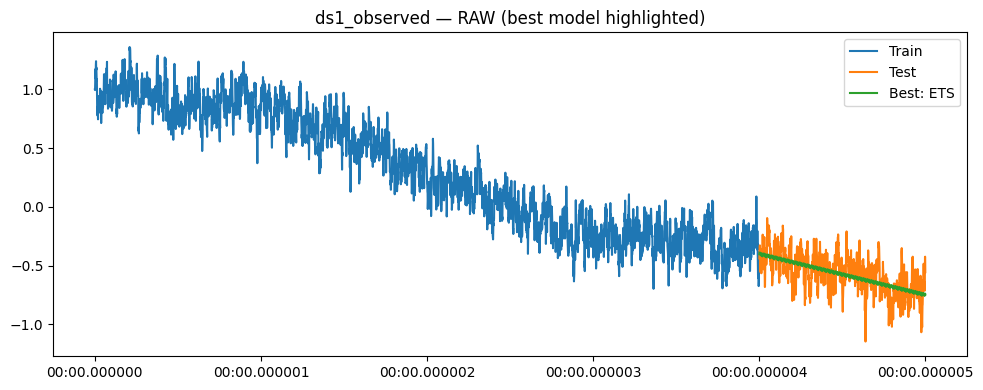

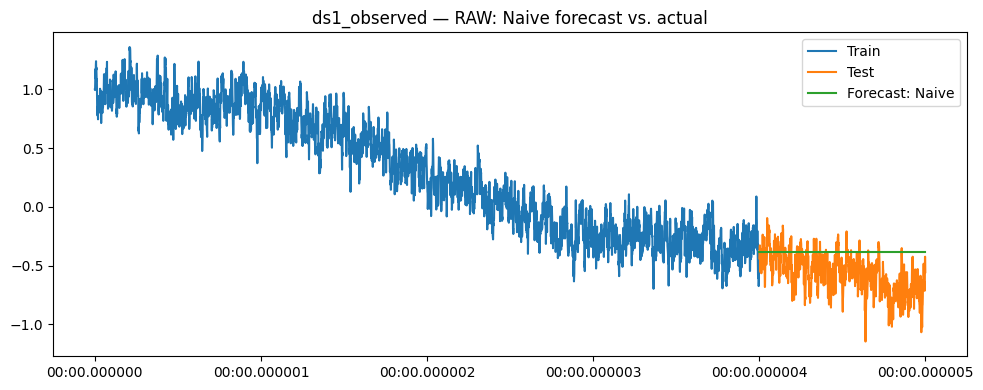

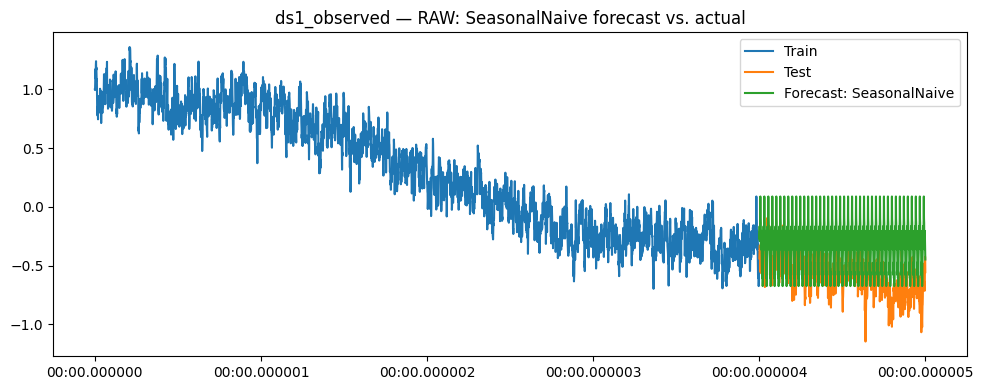

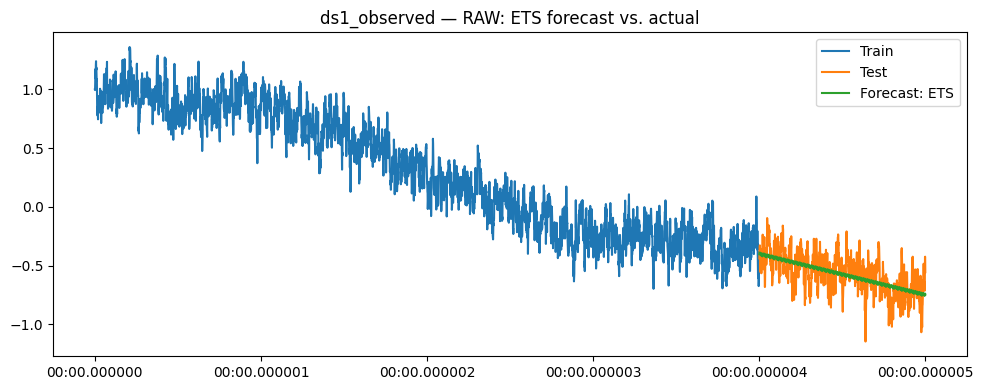

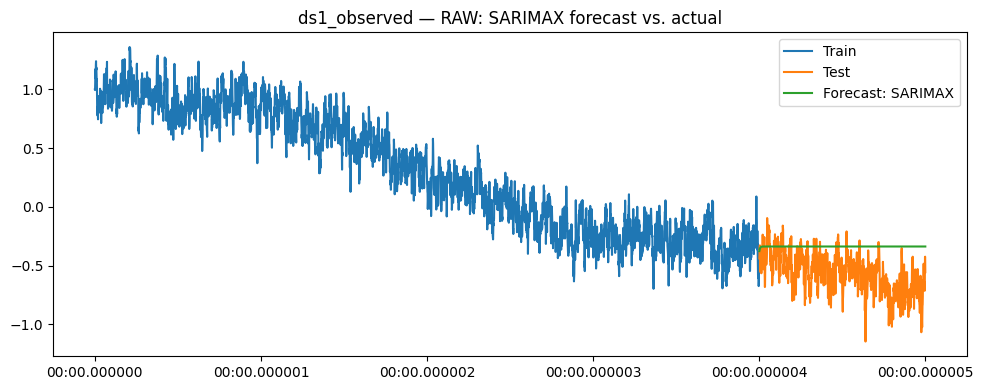

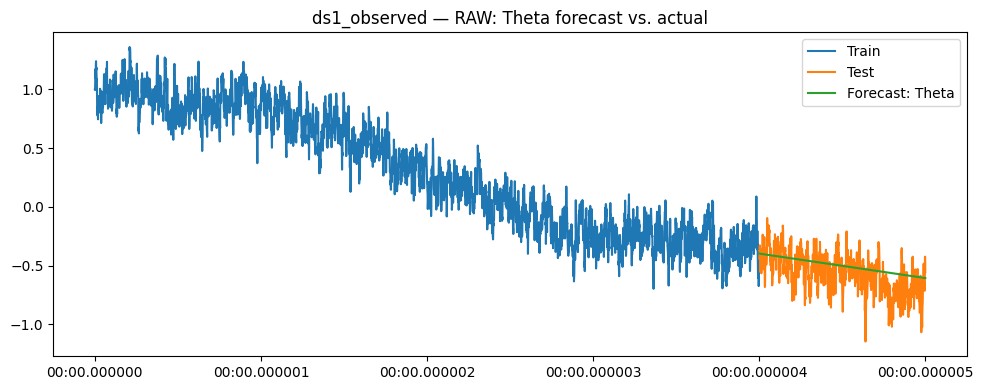


--- Evaluating variant: PREP (len=5000) ---
Performance (lower is better):
PREP:Theta        | sMAPE=12.19%  MAPE=11.50%  RMSE=0.09077
PREP:SARIMAX      | sMAPE=24.47%  MAPE=21.31%  RMSE=0.1662
PREP:Naive        | sMAPE=30.20%  MAPE=25.28%  RMSE=0.1934
PREP:SeasonalNaive | sMAPE=48.78%  MAPE=37.84%  RMSE=0.2614
PREP:ETS          | sMAPE=125.13%  MAPE=416.32%  RMSE=2.885


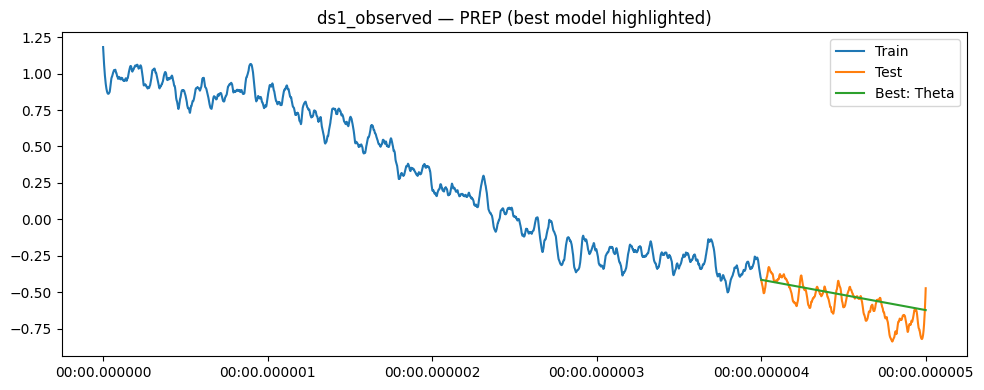

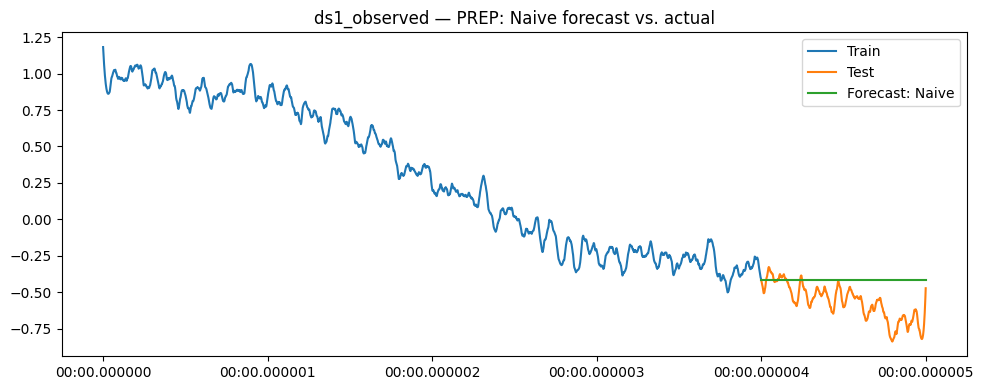

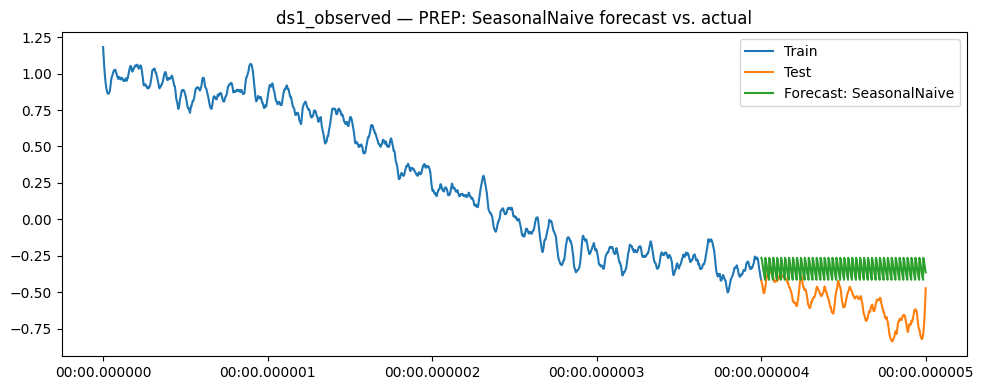

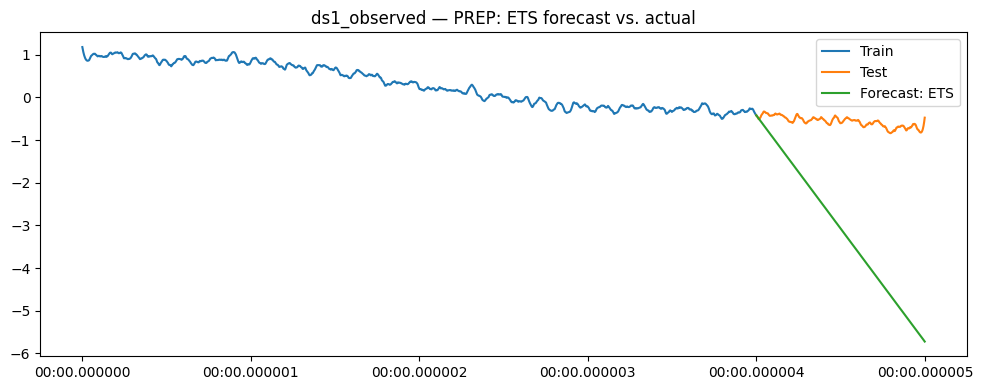

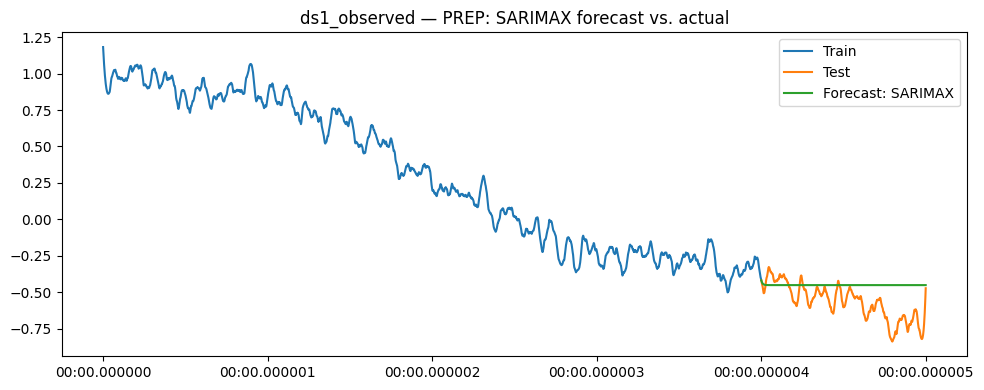

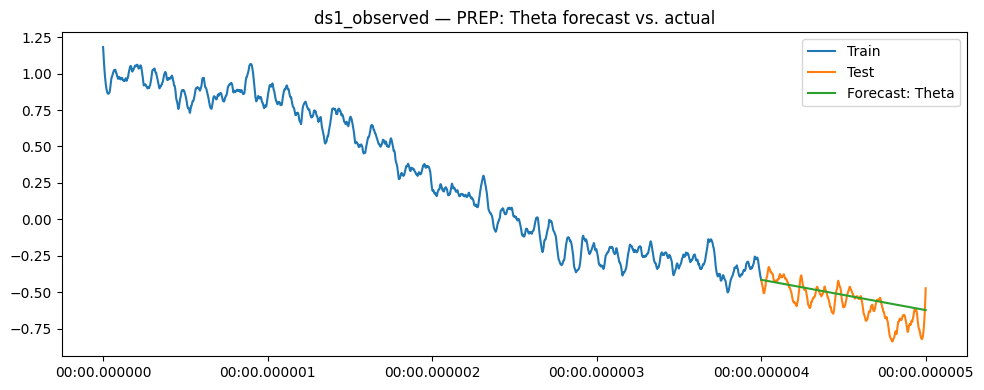


Best RAW:  ETS  sMAPE=20.11%
Best PREP: Theta sMAPE=12.19%
Δ sMAPE (PREP - RAW) = -7.93%  (positive = improvement)

Target series: ds2_observed
Inferred frequency: <Nano>
Seasonal candidates: [24, 168]

--- Evaluating variant: RAW (len=5000) ---
Performance (lower is better):
RAW:Naive        | sMAPE=13.74%  MAPE=14.44%  RMSE=0.1458
RAW:Theta        | sMAPE=13.76%  MAPE=14.18%  RMSE=0.1467
RAW:SARIMAX      | sMAPE=14.13%  MAPE=14.10%  RMSE=0.1507
RAW:ETS          | sMAPE=14.15%  MAPE=14.15%  RMSE=0.1504
RAW:SeasonalNaive | sMAPE=17.58%  MAPE=17.39%  RMSE=0.1838


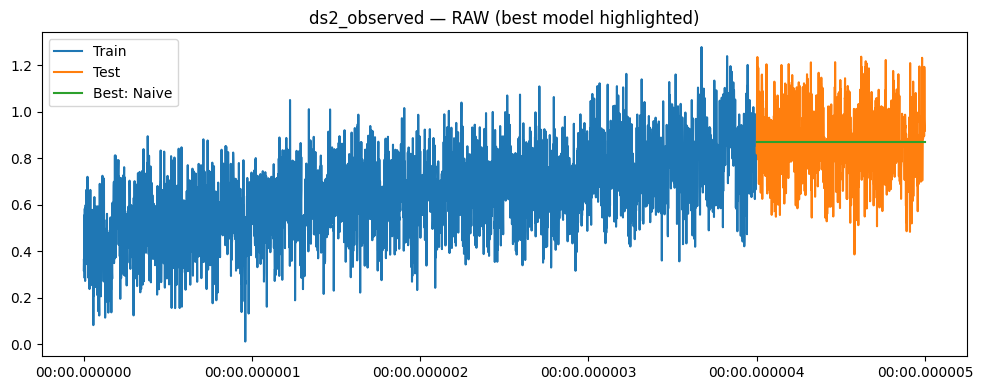

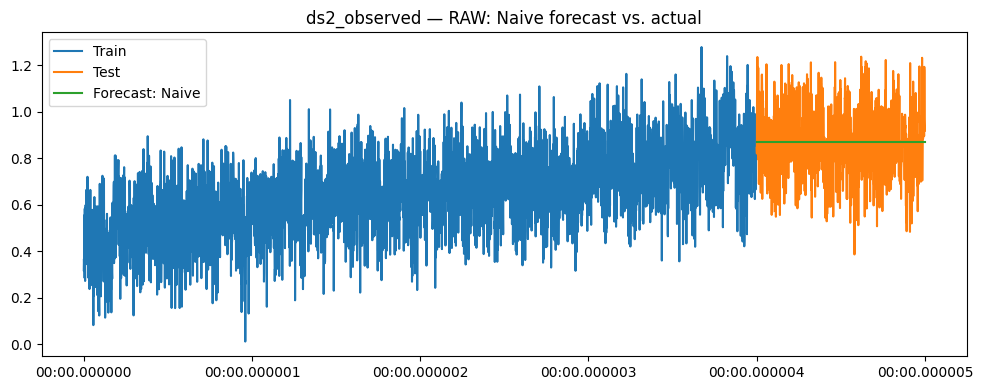

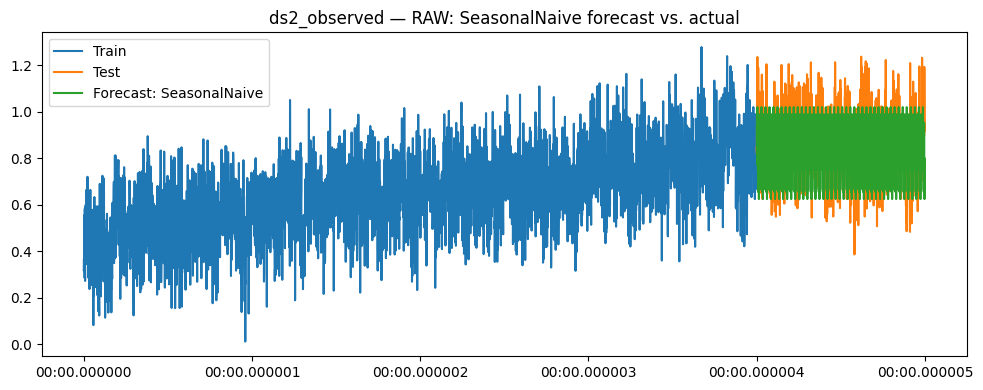

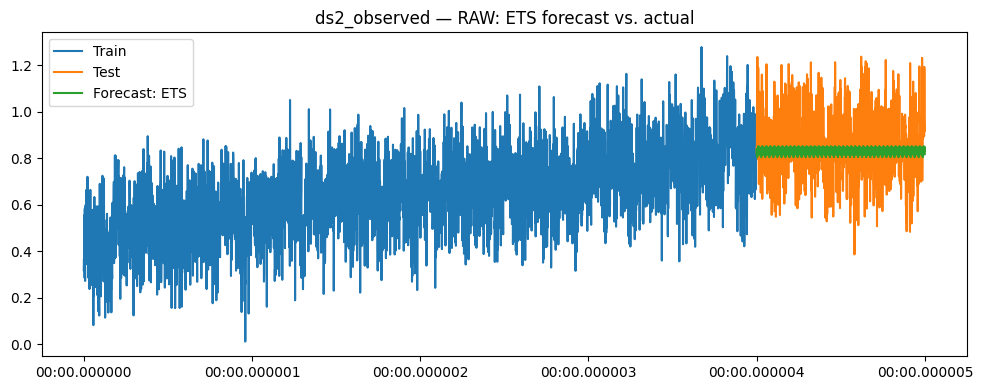

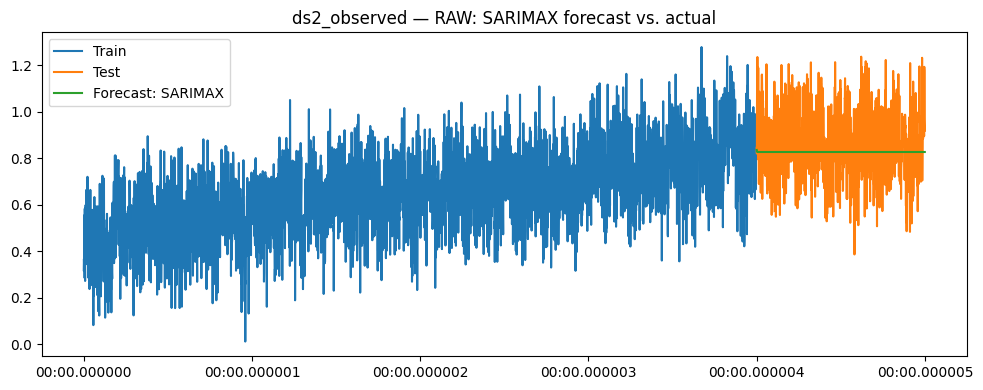

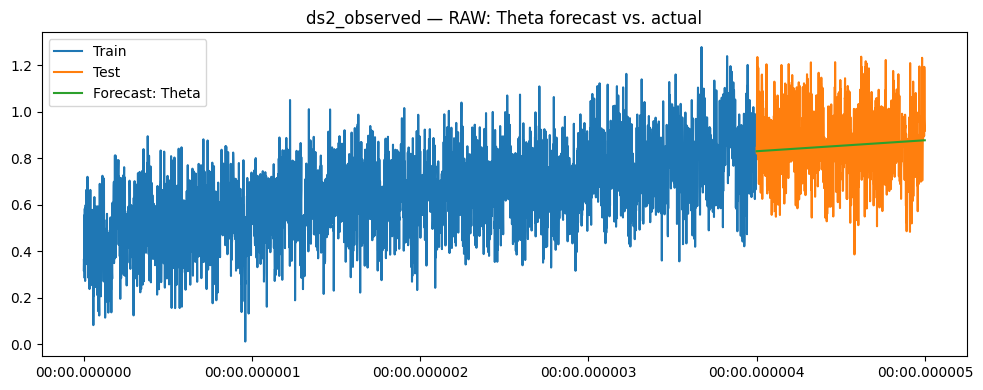


--- Evaluating variant: PREP (len=5000) ---
Performance (lower is better):
PREP:Naive        | sMAPE=4.84%  MAPE=4.86%  RMSE=0.0535
PREP:SARIMAX      | sMAPE=5.02%  MAPE=5.14%  RMSE=0.05566
PREP:Theta        | sMAPE=5.46%  MAPE=5.62%  RMSE=0.05891
PREP:SeasonalNaive | sMAPE=5.47%  MAPE=5.37%  RMSE=0.05909
PREP:ETS          | sMAPE=70.27%  MAPE=125.23%  RMSE=1.244


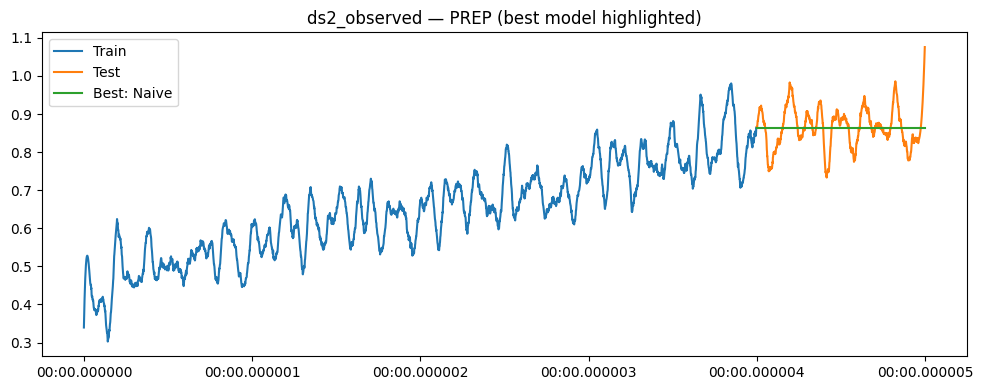

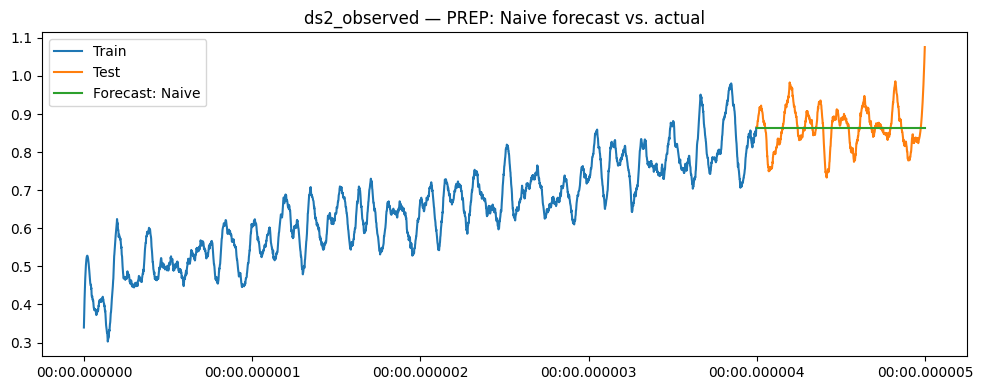

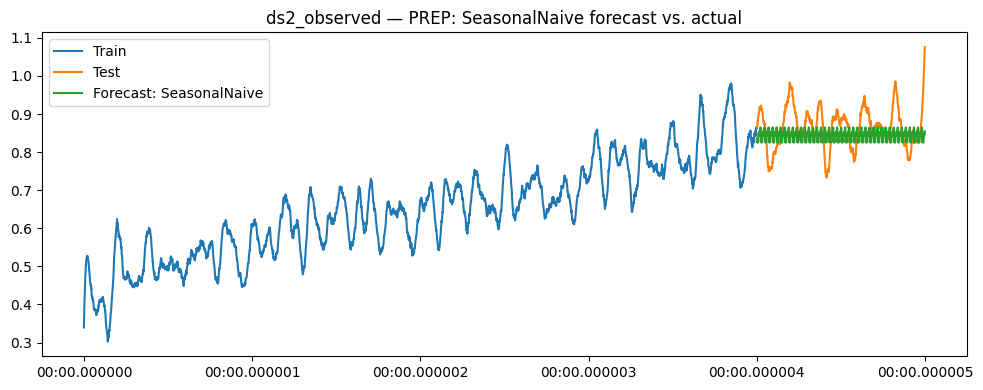

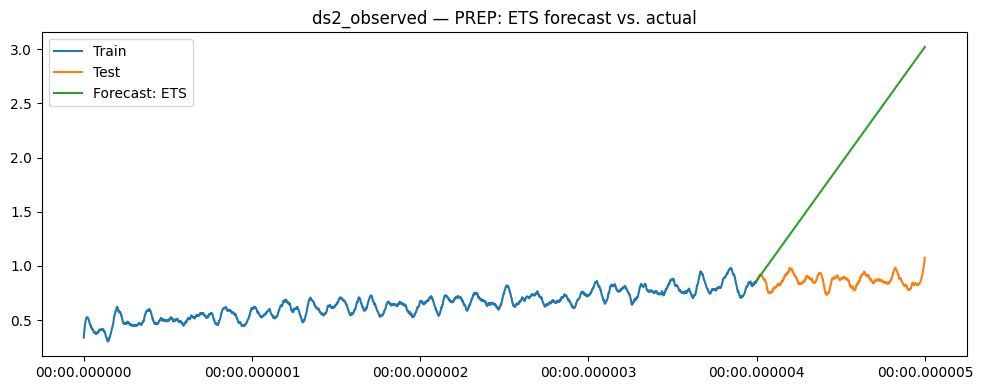

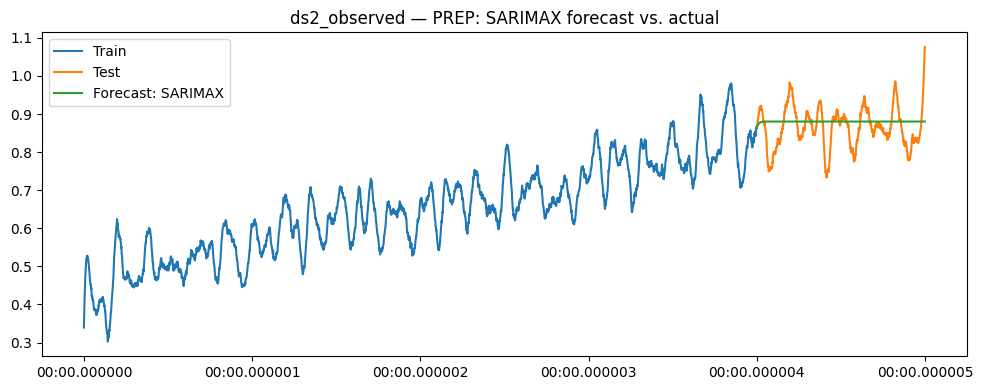

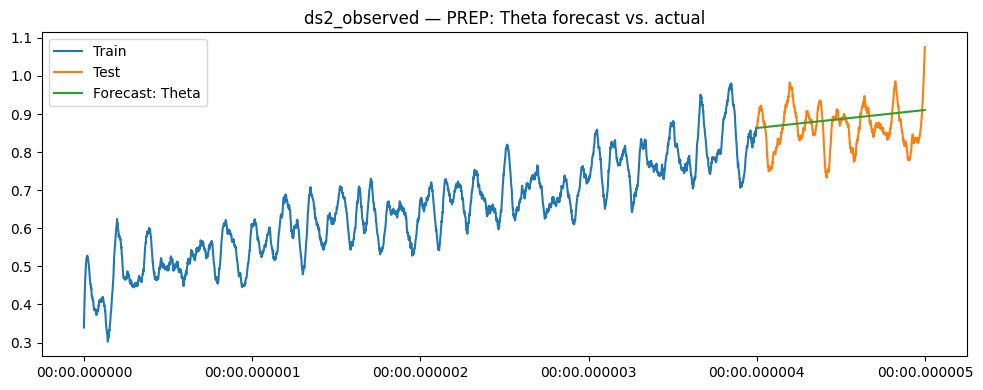


Best RAW:  Naive  sMAPE=13.74%
Best PREP: Naive sMAPE=4.84%
Δ sMAPE (PREP - RAW) = -8.90%  (positive = improvement)

Target series: ds3_observed
Inferred frequency: <Nano>
Seasonal candidates: [24, 168]

--- Evaluating variant: RAW (len=5000) ---
Performance (lower is better):
RAW:Theta        | sMAPE=72.49%  MAPE=493.46%  RMSE=0.2138
RAW:SARIMAX      | sMAPE=78.10%  MAPE=583.38%  RMSE=0.249
RAW:SeasonalNaive | sMAPE=78.78%  MAPE=640.57%  RMSE=0.2837
RAW:Naive        | sMAPE=79.65%  MAPE=599.16%  RMSE=0.2573
RAW:ETS          | sMAPE=82.28%  MAPE=627.96%  RMSE=0.2721


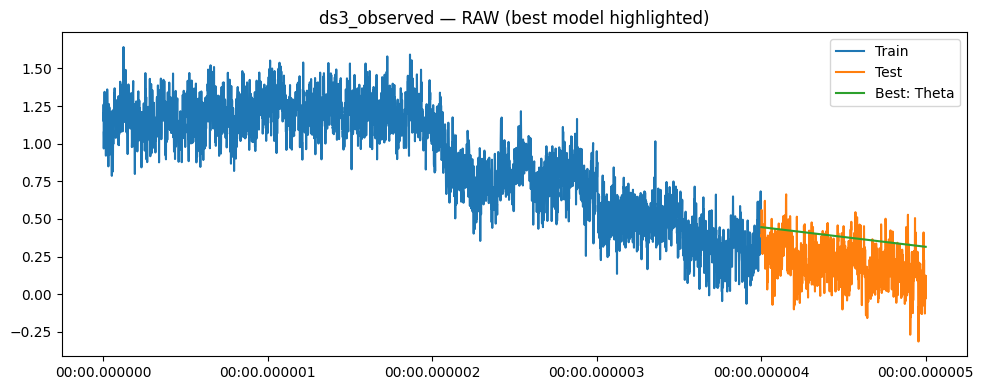

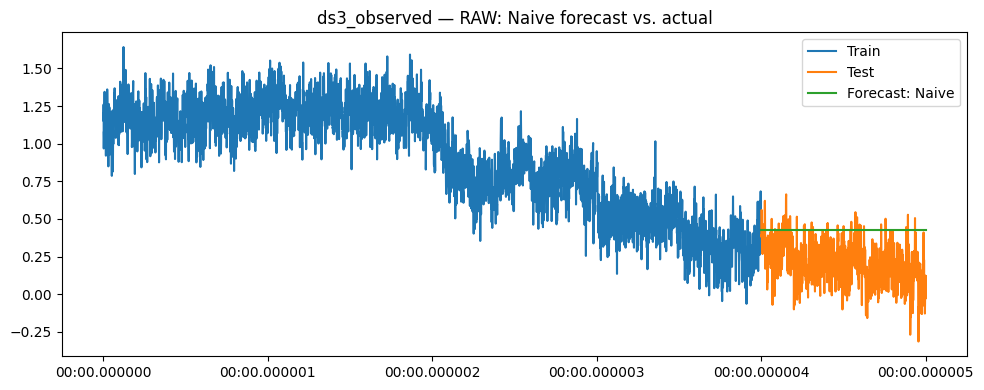

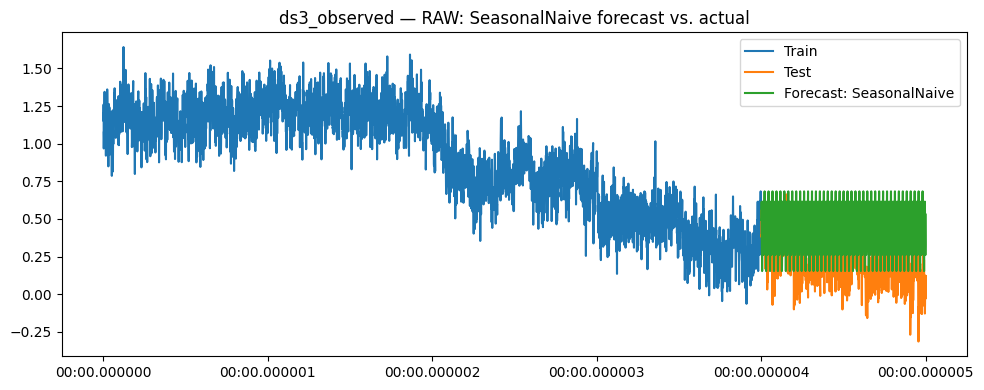

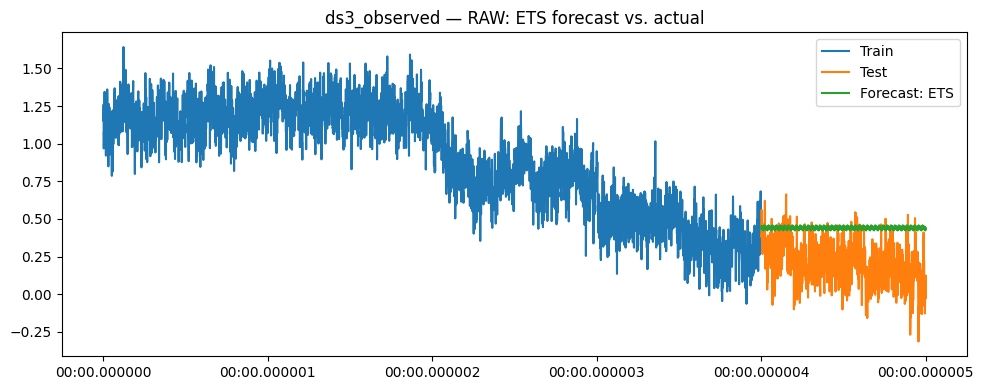

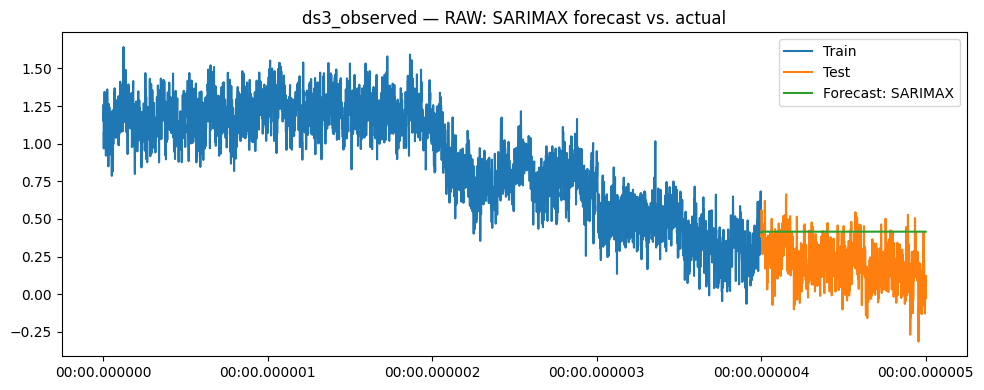

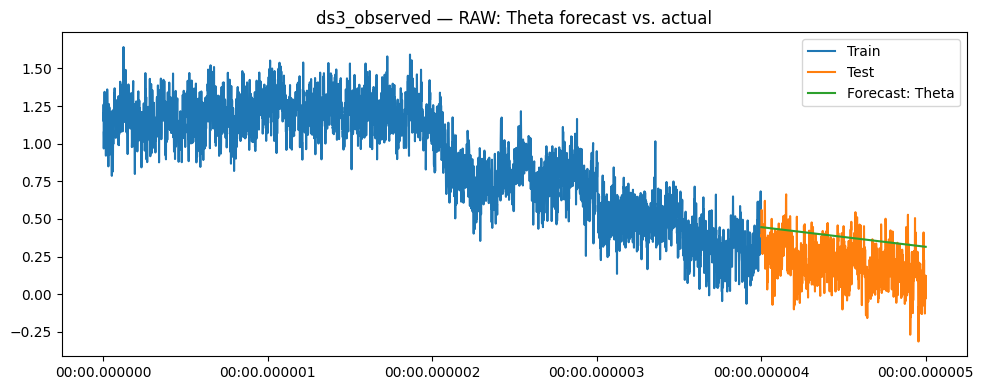


--- Evaluating variant: PREP (len=5000) ---
Performance (lower is better):
PREP:Theta        | sMAPE=58.63%  MAPE=105.63%  RMSE=0.1614
PREP:SeasonalNaive | sMAPE=68.93%  MAPE=142.16%  RMSE=0.213
PREP:Naive        | sMAPE=72.74%  MAPE=153.38%  RMSE=0.2303
PREP:SARIMAX      | sMAPE=76.97%  MAPE=166.76%  RMSE=0.2516
PREP:ETS          | sMAPE=138.51%  MAPE=905.01%  RMSE=1.408


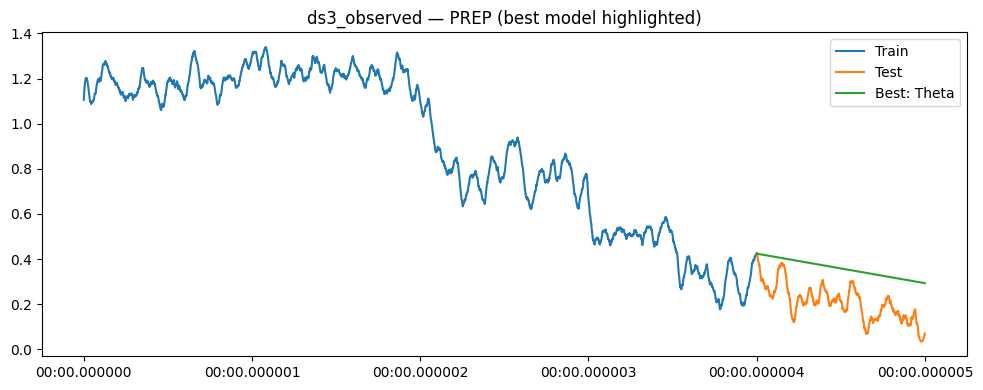

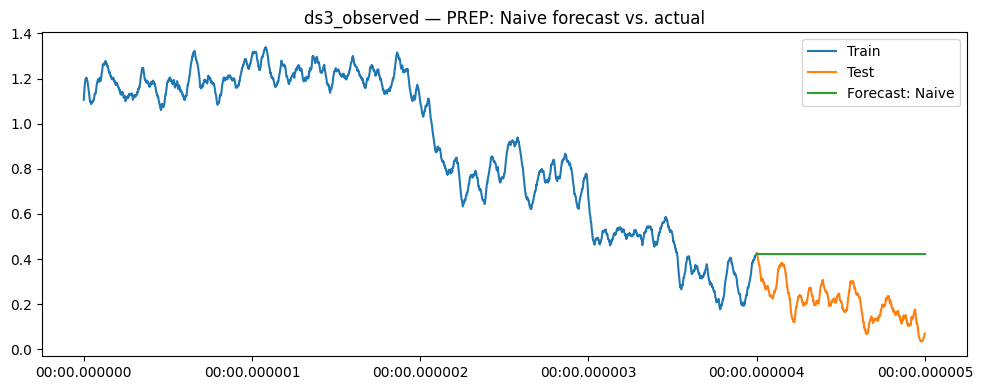

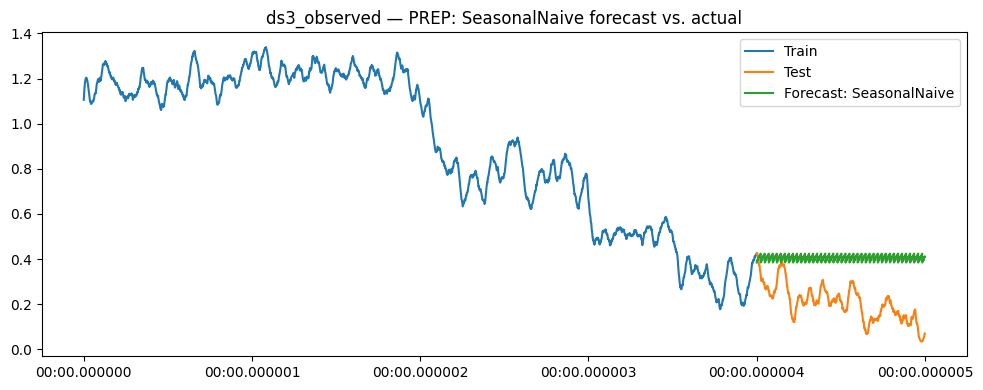

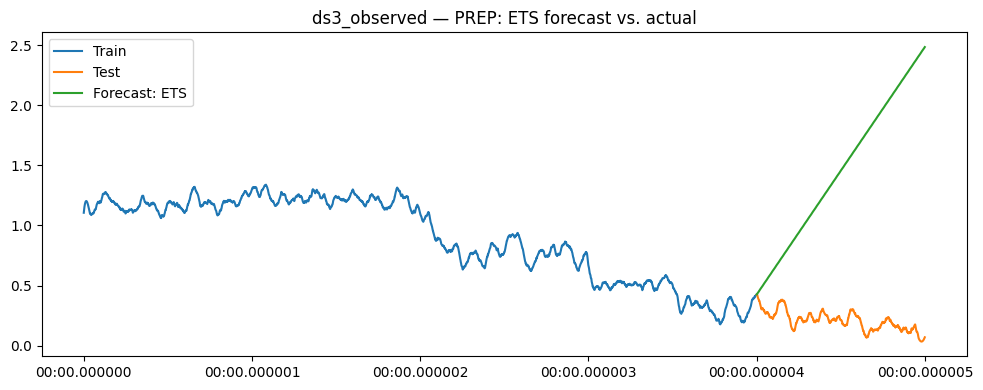

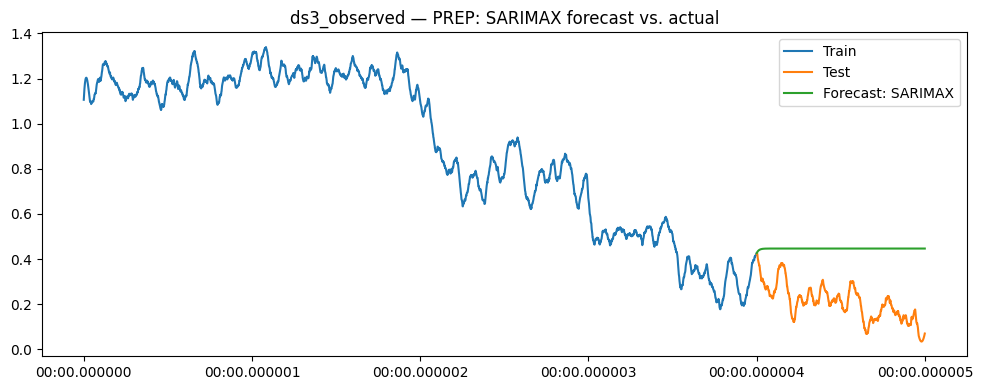

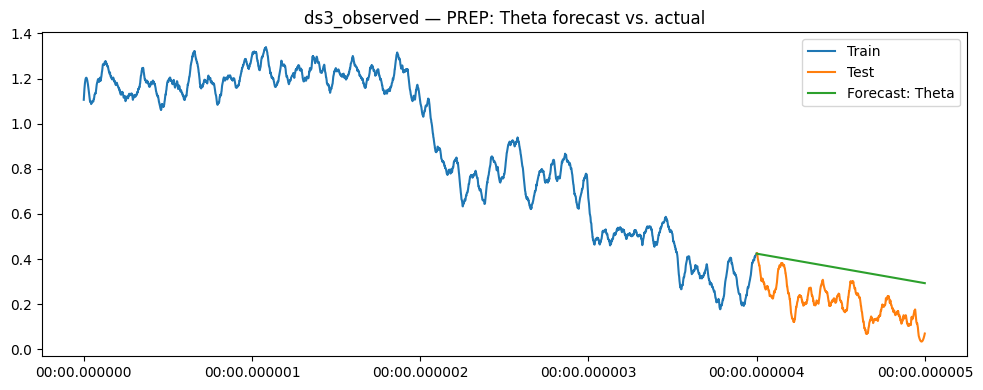


Best RAW:  Theta  sMAPE=72.49%
Best PREP: Theta sMAPE=58.63%
Δ sMAPE (PREP - RAW) = -13.86%  (positive = improvement)

Done. Tip: tune PREP_* switches (e.g., differencing/log) or set MANUAL_SEASONAL_PERIODS like [24, 24*7] / [7, 30] / [12].


In [ ]:
# %% [colab] --- Setup (safe to re-run) ---
!pip -q install tbats --progress-bar off

# %% [colab] --- Imports ---
import warnings, math, sys, itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from google.colab import files

# Statsmodels models
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Denoising
from scipy.signal import savgol_filter

# Optional multi-seasonal model
try:
    from tbats import TBATS
    _TBATS_AVAILABLE = True
except Exception:
    _TBATS_AVAILABLE = False

# %% [colab] --- User-adjustable switches ---
# If you know the seasonal periods, set them here (list of ints).
# Example hourly: [24, 24*7]; daily: [7, 30]; monthly: [12]
MANUAL_SEASONAL_PERIODS = [24, 24*7]

ENABLE_TBATS = True
TEST_SIZE_RATIO = 0.2
MAX_ETS_SECONDS = 30
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)

# Preprocessing defaults for the "PREP" variant
PREP_METHOD = "savgol"     # 'savgol', 'moving', or None
PREP_WINDOW_AUTO = True    # if True, window auto-scales with series length
PREP_WINDOW = 101          # used if PREP_WINDOW_AUTO=False
PREP_POLY = 3              # Savitzky–Golay polynomial order
PREP_LOG = False           # apply log1p if data > 0
PREP_DIFFERENCE = False    # first difference after smoothing?

# %% [colab] --- Upload CSV ---
print("Please upload your CSV (first column = time).")
uploaded = files.upload()
assert uploaded, "No file uploaded."
csv_path = list(uploaded.keys())[0]
print(f"Loaded: {csv_path}")

# %% [colab] --- Read CSV robustly ---
def read_csv_flex(path):
    for sep in [",",";","\t","|"]:
        try:
            df = pd.read_csv(path, sep=sep, engine="python")
            if df.shape[1] >= 2:
                return df
        except Exception:
            pass
    return pd.read_csv(path)

raw = read_csv_flex(csv_path)

# Assume first column is time axis
time_col = raw.columns[0]
df = raw.copy()
df[time_col] = pd.to_datetime(df[time_col], errors="coerce", infer_datetime_format=True)
if df[time_col].isna().all():
    raise ValueError("First column couldn't be parsed as datetime.")
df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)

# Keep numeric targets
num_cols = [c for c in df.columns if c != time_col and pd.api.types.is_numeric_dtype(df[c])]
if not num_cols:
    raise ValueError("No numeric columns found apart from the first time column.")
print(f"Detected time column: {time_col}")
print(f"Numeric target columns: {num_cols}")

df = df.set_index(time_col)

# %% [colab] --- Frequency inference & regularization ---
def infer_uniform_freq(idx):
    f = pd.infer_freq(idx)
    if f: return f
    if len(idx) < 3: return None
    diffs = (idx[1:] - idx[:-1]).value_counts()
    if len(diffs)==0: return None
    mode_delta = diffs.index[0]
    secs = int(mode_delta / np.timedelta64(1, 's'))
    if secs <= 0: return None
    if secs % (24*3600) == 0:
        d = secs // (24*3600); return f"{d}D" if d!=1 else "D"
    if secs % 3600 == 0:
        h = secs // 3600; return f"{h}H" if h!=1 else "H"
    if secs % 60 == 0:
        m = secs // 60; return f"{m}T" if m!=1 else "T"
    return f"{secs}S" if secs!=1 else "S"

def as_uniform_series(s: pd.Series):
    s = s.dropna()
    s = s[~s.index.duplicated(keep="first")]
    freq = infer_uniform_freq(s.index)
    if freq is None:
        if len(s.index) < 3: return s, None
        diffs = np.diff(s.index.view(np.int64))
        step = int(np.median(diffs))
        new_index = pd.date_range(s.index.min(), s.index.max(), freq=pd.to_timedelta(step, unit="ns"))
        s = s.reindex(new_index).interpolate(limit_direction="both")
        return s.asfreq(s.index.freq), s.index.freq
    else:
        s = s.asfreq(freq)
        if s.isna().any():
            s = s.interpolate(limit_direction="both")
        return s, s.index.freq

def default_seasonal_candidates(freq_str):
    if freq_str is None: return []
    f = str(freq_str).upper()
    if f.endswith('H') or f=='H': return [24, 24*7]            # hourly: daily + weekly
    if f.endswith('T') or 'MIN' in f: return [60, 60*24, 60*24*7]
    if f.endswith('S') or f=='S': return [60, 3600, 86400]
    if 'D' in f: return [7, 30]
    if 'W' in f: return [52]
    if f.startswith('M'): return [12]
    if f.startswith('Q'): return [4]
    return []

def strictly_positive(x): return np.all(np.asarray(x) > 0)

# %% [colab] --- Metrics ---
def smape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    denom = (np.abs(y) + np.abs(yhat)); denom[denom==0]=1e-9
    return 100*np.mean(2*np.abs(yhat-y)/denom)
def mape(y, yhat):
    y = np.asarray(y); y = np.where(y==0, 1e-9, y)
    return 100*np.mean(np.abs((y - np.asarray(yhat))/y))
def rmse(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    return np.sqrt(np.mean((yhat-y)**2))

# %% [colab] --- Preprocessing helpers ---
def _odd(n): return int(n) if int(n)%2==1 else int(n)+1

def preprocess_series(y, method="savgol", window=101, poly=3, log_transform=False, difference=False, auto_window=True):
    """
    Returns a preprocessed series aligned on the same index where possible.
    If differenced, the first element is dropped.
    """
    y_proc = y.copy()

    # Variance stabilization
    if log_transform and (y_proc > 0).all():
        y_proc = np.log1p(y_proc)

    # Window auto-scaling
    if auto_window:
        # window ~ 1-2% of series length, but at least 51 and at most 501; keep odd
        win = max(51, min(501, _odd(max(5, int(len(y_proc)*0.015)))))
    else:
        win = _odd(max(5, int(window)))

    # Smoothing
    if method == "savgol":
        if len(y_proc) < (poly+2):
            sm = y_proc.copy()
        else:
            win = min(win, len(y_proc)-(1-(len(y_proc)%2)))  # ensure <= len and odd
            if win < (poly+2): win = poly+3 if (poly+3)%2==1 else poly+4
            sm = pd.Series(savgol_filter(y_proc.values, window_length=win, polyorder=poly), index=y_proc.index)
        y_proc = sm
    elif method == "moving":
        y_proc = y_proc.rolling(win, min_periods=1, center=True).mean()
    elif method is None:
        pass

    # Differencing
    if difference:
        y_proc = y_proc.diff().dropna()

    return y_proc

# %% [colab] --- Model helpers (ETS / SARIMAX / Theta / TBATS) ---
from time import time

def fit_ets(y_train, seasonal_period):
    trend_opts = [None, 'add', 'mul']
    seasonal_opts = [None] if not seasonal_period or seasonal_period<2 else ['add','mul']
    best_aic, best_model = np.inf, None
    t0 = time()
    for tr in trend_opts:
        for se in seasonal_opts:
            if time()-t0 > MAX_ETS_SECONDS: break
            if (tr=='mul' or se=='mul') and not strictly_positive(y_train):
                continue
            try:
                m = ExponentialSmoothing(
                    y_train, trend=tr, seasonal=se,
                    seasonal_periods=(seasonal_period if se else None),
                    initialization_method="estimated"
                ).fit(optimized=True, use_brute=False)
                aic = getattr(m, "aic", np.inf)
                if aic < best_aic: best_aic, best_model = aic, m
            except: pass
    return best_model

def _candidate_sarimax_orders(s_period):
    """Small, fast grid."""
    orders = [(0,0,0),(1,0,0),(0,1,1),(1,1,1),(2,1,1)]
    seas_orders = [(0,0,0,0)]
    if s_period and s_period>=2:
        seas_orders = [(0,0,0,s_period),(1,0,0,s_period),(0,1,1,s_period),(1,1,1,s_period)]
    return orders, seas_orders

def fit_sarimax_best(y_train, s_period):
    best_aic, best_model = np.inf, None
    orders, seas = _candidate_sarimax_orders(s_period)
    for (p,d,q) in orders:
        for (P,D,Q,m) in seas:
            try:
                model = SARIMAX(
                    y_train, order=(p,d,q),
                    seasonal_order=(P,D,Q,m),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)
                aic = model.aic
                if aic < best_aic:
                    best_aic, best_model = aic, model
            except:
                continue
    return best_model

def fit_theta(y_train):
    try: return ThetaModel(y_train, deseasonalize=False).fit()
    except: return None

def fit_tbats(y_train, seasonal_periods_list):
    if not (_TBATS_AVAILABLE and ENABLE_TBATS): return None
    if not seasonal_periods_list or len(seasonal_periods_list)<2: return None
    try:
        est = TBATS(
            seasonal_periods=seasonal_periods_list,
            use_box_cox=False, use_trend=True, use_damped_trend=True,
            use_arma_errors=False, n_jobs=1
        )
        return est.fit(y_train)
    except: return None

# %% [colab] --- Main loop: RAW vs PREP per series ---
def evaluate_variant(y, label, candidates):
    """Run baselines + models and return (forecasts dict, metrics dict, leaderboard list)."""
    s_period = int(candidates[0]) if candidates else None

    n = len(y)
    h = max(1, int(round(TEST_SIZE_RATIO*n)))
    y_train, y_test = y.iloc[:-h], y.iloc[-h:]

    forecasts, metrics = {}, {}

    # Baselines
    forecasts["Naive"] = pd.Series(np.full(h, y_train.iloc[-1]), index=y_test.index)
    if s_period and len(y_train)>s_period:
        base = y_train.iloc[-s_period:].values
        forecasts["SeasonalNaive"] = pd.Series(np.resize(base, h), index=y_test.index)

    # ETS
    ets_model = fit_ets(y_train, s_period)
    if ets_model is not None:
        try: forecasts["ETS"] = pd.Series(ets_model.forecast(h), index=y_test.index)
        except: pass

    # SARIMAX
    sarimax_model = fit_sarimax_best(y_train, s_period)
    if sarimax_model is not None:
        try: forecasts["SARIMAX"] = pd.Series(sarimax_model.forecast(steps=h), index=y_test.index)
        except: pass

    # Theta
    theta_model = fit_theta(y_train)
    if theta_model is not None:
        try: forecasts["Theta"] = pd.Series(theta_model.forecast(h), index=y_test.index)
        except: pass

    # TBATS (multi-seasonal)
    tbats_model = fit_tbats(y_train, candidates if candidates else [])
    if tbats_model is not None:
        try: forecasts["TBATS"] = pd.Series(tbats_model.forecast(steps=h), index=y_test.index)
        except: pass

    # Metrics
    for name, yhat in forecasts.items():
        metrics[name] = {"sMAPE": smape(y_test, yhat), "MAPE": mape(y_test, yhat), "RMSE": rmse(y_test, yhat)}
    leaderboard = sorted(metrics.items(), key=lambda kv: kv[1]["sMAPE"])

    return (y_train, y_test, forecasts, metrics, leaderboard)

all_results = []

for col in num_cols:
    print("\n" + "="*100)
    print(f"Target series: {col}")
    y_raw0 = df[col].astype(float).copy()

    # Regularize index / fill tiny gaps
    y_raw, freq = as_uniform_series(y_raw0)
    print(f"Inferred frequency: {freq}")

    # Seasonality
    candidates = MANUAL_SEASONAL_PERIODS if MANUAL_SEASONAL_PERIODS else default_seasonal_candidates(freq)
    print("Seasonal candidates:", candidates if candidates else "None")

    # Build RAW and PREP variants
    y_var = {
        "RAW": y_raw,
        "PREP": preprocess_series(
            y_raw,
            method=PREP_METHOD,
            window=PREP_WINDOW,
            poly=PREP_POLY,
            log_transform=PREP_LOG,
            difference=PREP_DIFFERENCE,
            auto_window=PREP_WINDOW_AUTO
        )
    }

    variant_summaries = {}

    # Evaluate both variants
    for vname, y in y_var.items():
        print(f"\n--- Evaluating variant: {vname} (len={len(y)}) ---")
        y_train, y_test, forecasts, metrics, leaderboard = evaluate_variant(y, vname, candidates)

        # Print leaderboard
        print("Performance (lower is better):")
        for name, m in leaderboard:
            print(f"{vname}:{name:<12s} | sMAPE={m['sMAPE']:.2f}%  MAPE={m['MAPE']:.2f}%  RMSE={m['RMSE']:.4g}")

        # Plot overview (best model)
        plt.figure(figsize=(10,4))
        plt.plot(y_train.index, y_train.values, label="Train")
        plt.plot(y_test.index, y_test.values, label="Test")
        if leaderboard:
            best_name = leaderboard[0][0]
            plt.plot(forecasts[best_name].index, forecasts[best_name].values, label=f"Best: {best_name}")
        plt.title(f"{col} — {vname} (best model highlighted)")
        plt.legend(); plt.tight_layout(); plt.show()

        variant_summaries[vname] = {
            "y_train": y_train, "y_test": y_test,
            "forecasts": forecasts, "metrics": metrics, "leaderboard": leaderboard
        }

        # Optional: per-model plots
        for name, yhat in forecasts.items():
            plt.figure(figsize=(10,4))
            plt.plot(y_train.index, y_train.values, label="Train")
            plt.plot(y_test.index, y_test.values, label="Test")
            plt.plot(yhat.index, yhat.values, label=f"Forecast: {name}")
            plt.title(f"{col} — {vname}: {name} forecast vs. actual")
            plt.legend(); plt.tight_layout(); plt.show()

    # Quick RAW vs PREP best comparison by sMAPE
    best_raw = variant_summaries["RAW"]["leaderboard"][0] if variant_summaries["RAW"]["leaderboard"] else None
    best_prep = variant_summaries["PREP"]["leaderboard"][0] if variant_summaries["PREP"]["leaderboard"] else None
    if best_raw and best_prep:
        print(f"\nBest RAW:  {best_raw[0]}  sMAPE={best_raw[1]['sMAPE']:.2f}%")
        print(f"Best PREP: {best_prep[0]} sMAPE={best_prep[1]['sMAPE']:.2f}%")
        delta = best_raw[1]['sMAPE'] - best_prep[1]['sMAPE']
        print(f"Δ sMAPE (PREP - RAW) = {(-delta):+.2f}%  (positive = improvement)")

    all_results.append({
        "series": col,
        "frequency": str(freq),
        "seasonal_candidates": candidates,
        "RAW_leader": best_raw,
        "PREP_leader": best_prep,
        "variants": variant_summaries
    })

print("\nDone. Tip: tune PREP_* switches (e.g., differencing/log) or set MANUAL_SEASONAL_PERIODS like [24, 24*7] / [7, 30] / [12].")